In [1]:
# imports
%matplotlib inline
import re
import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np
import pandas as pd
import glob

In [34]:
mu = 1.5e-8  # mutation rate
r = 1.0e-8  # recombination rate
N = 10000  # diploid population size in the sexual ancestor
chromLength = int(1e7)  # 10 Mbp per chromosome
numChromosomes = 100  # simulate 100 chromosomes per replicate

# scaled parameters for entire chromosomes
rho = 4*N*r*chromLength
theta = 4*N*mu*chromLength

numReps = 5

# the different transition times to test
asexGens = np.array([2000, 5000, 10000, 20000, 40000])
asexGensRescaled = asexGens / (2.0*N)  # rescaled by 2*N

## initial simulation: constant population size history, diploid asexuals

In [35]:
# generate ms commands (but using scrm instead of ms)
# scrm: http://scrm.github.io/ 

msCmds = open('sim_ms_commands.txt', 'w')
for asexGen in asexGensRescaled:
    for rep in xrange(1, numReps+1):
        filename = "sim_data_t{}_rho{}_asex{}_rep{}".format(theta, rho, asexGen, rep)
        msCmd = "scrm 2 {numChroms} -t {theta} -r {rho} {chromLen} | ./add_asex.py - {asexGen} > {filename}".format(numChroms = numChromosomes,
                                                                   theta = theta, rho = rho,
                                                                   chromLen = chromLength, asexGen = asexGen,
                                                                   filename = filename)
        msCmds.write(msCmd+'\n')
# control runs with constant size and no history of asex
for rep in xrange(1,numReps+1):
    filename = "sim_data_t{}_rho{}_no_asex_rep{}".format(theta, rho, rep)
    msCmd = "scrm 2 {numChroms} -t {theta} -r {rho} {chromLen} > {filename}".format(numChroms = numChromosomes,
                                                               theta = theta, rho = rho,
                                                               chromLen = chromLength,
                                                               filename = filename)
    msCmds.write(msCmd+'\n')
msCmds.close()

Simulate the data.

    cat sim_ms_commands.txt | parallel -j 4
    mkdir -p simdata
    mv sim_data* simdata/

Convert to psmc format.
    
    for file in simdata/sim_data_*
    do
        psmcfilename="$file.psmc"
        ./ms2psmcfa.py $file > $psmcfilename
    done

In [36]:
datadir = "simdata"

In [37]:
# make psmc commands

initialT = "0.5"

psmcCmds = open('sim_psmc_commands.txt', 'w')

for asexGen in asexGensRescaled:
    for rep in xrange(1, numReps+1):
        datafilename = "{}/sim_data_t{}_rho{}_asex{}_rep{}.psmc".format(datadir, theta, rho, asexGen, rep)
        resultsfilename = "{}/results_data_t{}_rho{}_asex{}_rep{}".format(datadir, theta, rho, asexGen, rep)
        resultsfilenameT = "{}/results_data_t{}_rho{}_asex{}_rep{}_T".format(datadir, theta, rho, asexGen, rep)
        psmcCmd = "psmc {} > {}".format(datafilename, resultsfilename)
        psmcCmdT = "psmc {} -T {} > {}".format(datafilename, initialT, resultsfilenameT)
        psmcCmds.write(psmcCmd+'\n')
        psmcCmds.write(psmcCmdT+'\n')
# control runs with constant size and no history of asex
psmcCmds = open('sim_psmc_commands_complete.txt', 'w')
for rep in xrange(1,numReps+1):
    datafilename = "{}/sim_data_t{}_rho{}_no_asex_rep{}.psmc".format(datadir, theta, rho, rep)
    resultsfilename = "{}/results_data_t{}_rho{}_no_asex_rep{}".format(datadir, theta, rho, rep)
    resultsfilenameT = "{}/results_data_t{}_rho{}_no_asex_rep{}_T".format(datadir, theta, rho, rep)
    psmcCmd = "psmc {} > {}".format(datafilename, resultsfilename)
    psmcCmdT = "psmc {} -T {} > {}".format(datafilename, initialT, resultsfilenameT)
    psmcCmds.write(psmcCmd+'\n')
    psmcCmds.write(psmcCmdT+'\n')
psmcCmds.close()

In [38]:
# read and return psmc results as dict

def read_psmc_results(filename):
    results = {}
    results['divtime'] = None  # divtime None by default...
    fin = open(filename,'r')
    for line in fin:
        line = line.strip()
        if line[:2] == 'TR':
            spline = line.split('\t')
            results['theta'] = float(spline[1])
            results['rho'] = float(spline[2])
            continue
        if line[:2] == 'DT':
            results['divtime'] = float(line.split('\t')[1])
            continue
        if line[:2] == 'RS':
            spline = line.split('\t')
            i = int(spline[1])
            ti = float(spline[2])
            lambdai = float(spline[3])
            results['maxi'] = i
            results['t{}'.format(i)] = ti
            results['lambda{}'.format(i)] = lambdai
            continue
    return results

In [39]:
# get psmc data

rows = {}
for asexGen, asexGenUnscaled in zip(asexGensRescaled, asexGens):
    for rep in xrange(1, numReps+1):
        index = 'asex{}_rep{}'.format(asexGen, rep)
        resultsfilename = "{}/results_data_t{}_rho{}_asex{}_rep{}".format(datadir, theta, rho, asexGen, rep)
        try:
            results = read_psmc_results(resultsfilename)
            results['asex'] = asexGenUnscaled
            results['rep'] = rep
            rows[index] = results
        except:
            pass
        index = 'asex{}_rep{}_T'.format(asexGen, rep)
        resultsfilename = "{}/results_data_t{}_rho{}_asex{}_rep{}_T".format(datadir, theta, rho, asexGen, rep)
        try:
            results = read_psmc_results(resultsfilename)
            results['asex'] = asexGenUnscaled
            results['rep'] = rep
            rows[index] = results 
        except:
            pass
        
for rep in xrange(1, numReps+1):
    index = 'noasex_rep{}'.format(rep)
    resultsfilename = "{}/results_data_t{}_rho{}_no_asex_rep{}".format(datadir, theta, rho, rep)
    try:
        results = read_psmc_results(resultsfilename)
        results['asex'] = None
        results['rep'] = rep
        rows[index] = results
    except:
        pass

In [40]:
# make a dataframe for psmc data

dat = pd.DataFrame.from_dict(rows, orient = 'index')
maxi = int(dat['maxi'].max())
newCols = ['asex', 'rep', 'theta', 'rho', 'divtime']
newCols.extend(['lambda'+str(i) for i in xrange(0,maxi+1)])
newCols.extend(['t'+str(i) for i in xrange(0,maxi+1)])
newCols.append('maxi')
dat = dat[newCols]

In [41]:
# rescaling the population sizes and times

binSize = 100  # we binned the bp's by 100 in the input to PSMC

dat['lambda0'] = dat['theta'] / (4.0*mu) / binSize

dat['divtime'] = 2.0*dat['lambda0'] * dat['divtime']

for i in xrange(1, maxi+1):
    colLam = 'lambda'+str(i)
    colT = 't'+str(i)
    dat[colLam] = dat['lambda0'] * dat[colLam]
    dat[colT] = 2.0*dat['lambda0'] * dat[colT]

In [42]:
# function to plot psmc data

def plot_psmc(axis, ts, lambdas, divtime = None, maxt = None, **plotkwargs):
    newTs = np.repeat(np.array(ts), 2)[1:]
    newLambdas = np.repeat(np.array(lambdas), 2)[:-1]
    if divtime is None:
        axis.plot(newTs, np.log10(newLambdas), '-', **plotkwargs)
    else:
        baseline, = axis.plot(newTs+divtime, np.log10(newLambdas), '-', **plotkwargs)
        if 'color' not in plotkwargs:
            axis.axvline(x = divtime, color = baseline.get_color(), **plotkwargs)
        else:
            axis.axvline(x = divtime, **plotkwargs)
    if maxt is not None:
        axis.set_xlim((0, maxt))
    return

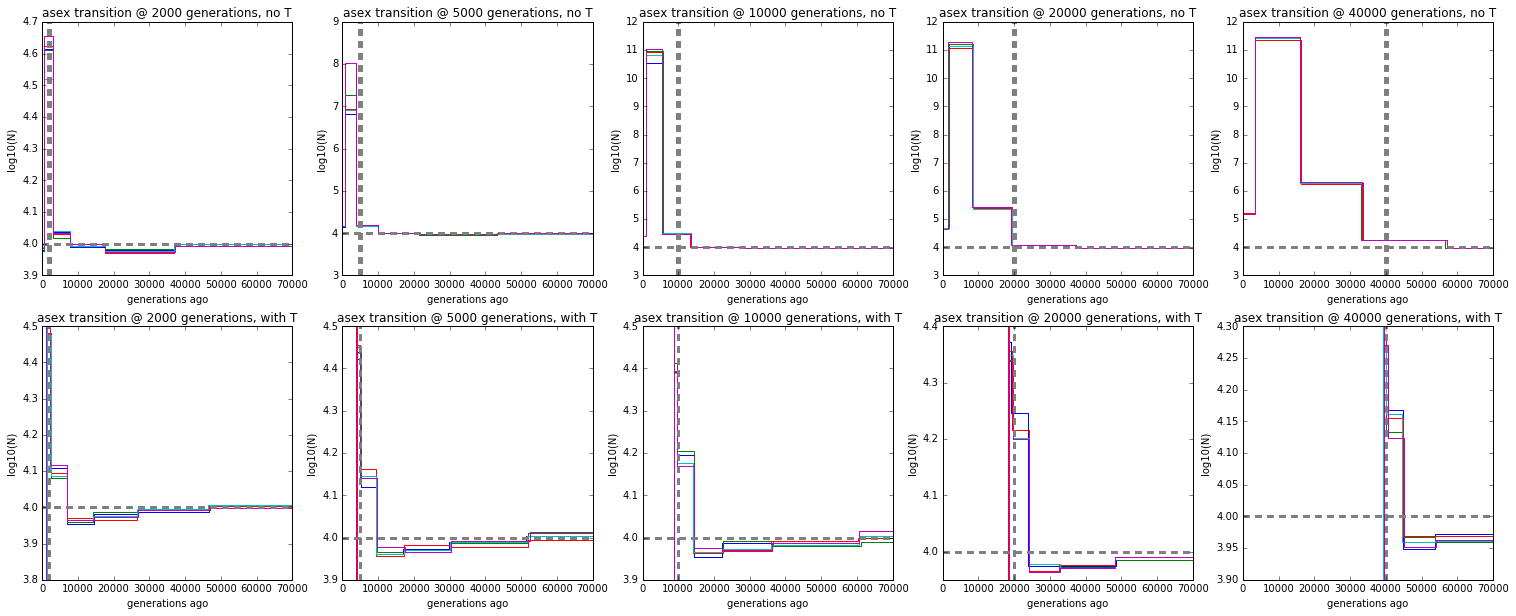

In [43]:
# plot the psmc data

fig, axes = plt.subplots(nrows=2,ncols=len(asexGens), figsize = (26,10))
for colIdx, asexGen in enumerate(asexGens):
    # first row: no T
    datp = dat.loc[(dat['asex'] == asexGen) & (np.isnan(dat['divtime'])),:]
    axis = axes[0, colIdx]
    for rowIdx in xrange(datp.shape[0]):
        maxi = int(datp.ix[rowIdx,'maxi'])
        ts = datp.ix[rowIdx,'t0':('t{}'.format(maxi))]
        lambdas = datp.ix[rowIdx, 'lambda0':('lambda{}'.format(maxi))]
        divtime = datp.ix[rowIdx, 'divtime']
        if np.isnan(divtime):
            divtime = None
        plot_psmc(axis, ts, lambdas, divtime, maxt = 70000)
        axis.axvline(asexGen, color = 'gray', lw = 5, ls = 'dashed')
        axis.axhline(np.log10(N), color = 'gray', lw = 3, ls = 'dashed')
        axis.set_title('asex transition @ {} generations, no T'.format(asexGen))
        axis.set_xlabel('generations ago')
        axis.set_ylabel('log10(N)')
    # second row: T
    datp = dat.loc[(dat['asex'] == asexGen) & (~np.isnan(dat['divtime'])),:]
    axis = axes[1, colIdx]
    for rowIdx in xrange(datp.shape[0]):
        maxi = int(datp.ix[rowIdx,'maxi'])
        ts = datp.ix[rowIdx,'t0':('t{}'.format(maxi))]
        lambdas = datp.ix[rowIdx, 'lambda0':('lambda{}'.format(maxi))]
        divtime = datp.ix[rowIdx, 'divtime']
        if np.isnan(divtime):
            divtime = None
        plot_psmc(axis, ts, lambdas, divtime, maxt = 70000)
        # add true divergence time
        axis.axvline(asexGen, color = 'gray', lw = 3, ls = 'dashed')
        axis.axhline(np.log10(N), color = 'gray', lw = 3, ls = 'dashed')
        axis.set_title('asex transition @ {} generations, with T'.format(asexGen))
        axis.set_xlabel('generations ago')
        axis.set_ylabel('log10(N)')
        

**Figure caption:** Inferred sex-to-asex transition times using the diploid PSMC with simulated diploid asexual genome data. In each panel, there are five lines, one line for each of five replicate datasets. The true population size is shown as a horizontal dashed gray line. The true time of the transition from sexual to asexual reproduction is shown as a vertical dashed gray line. The top row shows the results leaving out the `-T` parameter; the period of asexual reproduction is inferred as a period of increased population size. The lower row shows the effect of enabling the `-T` parameter in PSMC. This parameter is an aborted attempt to model the divergence between two populations; it doesn't work for that scenario, but it is perfect for this particular scenario. In the lower row, the inferred sex-to-asex transition time is shown with the colored solid vertical lines.

It seems like the -T parameter accurately estimates the time since the sex to asex transition time, at least when there is no history of population size changes. The transition is also visible in population size trajectory without the -T option specified (top row), but it is harder to read from the trajectory of N. The estimate of the transition time seems to be somewhat underestimated, with an upwards bias of N directly following the transition. This may be the effect of using SMC math where the SMC' is really needed.

Next: do diploid simulations with recent population growth, see whether PSMC can disentangle these two effects. One reason to be optimistic: In the top row above, the inferred increase in population size in the recent past is several orders of magnitude, which will probably not be the case in nature.

## including historical changes in population size

First going to use "PSMC standard simulation" from their paper, see true population size history in Fig. 2 of Li and Durbin (2011).

The ms command to generate their "standard simulation," from the paper:

    ms 2 100 -t 81960 -r 13560 30000000 -eN 0.01 0.05 -eN 0.0375 0.5 -eN 1.25 1

This sets $N_0 = 28000$, $\theta = 4N_0\mu = 81960$,
thus $\mu = 2.44 \times 10^{-8}$, $\rho = 4N_0r = 13560$, thus
$r = 4.04 \times 10^{-9}$.

Changes in population size:

 - at 1120 generations, $N_0 \to N_1 = 1400$
 - at 4200 generations, $N_1 \to N_2 = 14000$
 - at 140000 generations, $N_2 \to N_3 = 28000$

Again, we will add $\{2000, 5000, 10000, 20000, 40000\}$ generations of asexual reproduction and see how PSMC determines these transition times from the genome-wide signal of the Meselson effect.

In [12]:
# generate new ms (scrm) commands

stdMsCmd = "scrm 2 100 -t 81960 -r 13560 30000000 -eN 0.01 0.05 -eN 0.0375 0.5 -eN 1.25 1"

datadir = "stdsimdata"

stdN0 = 28000

stdAsexGensRescaled = asexGens/(2.0*stdN0)

stdMsCmds = open('sim_ms_commands_standard.txt', 'w')
for asexGen in stdAsexGensRescaled:
    for rep in xrange(1, numReps+1):
        filename = "{}/standard_sim_data_t{}_rho{}_asex{}_rep{}".format(datadir, theta, rho, asexGen, rep)
        msCmd = stdMsCmd + ' | ./add_asex.py - {asexGen} > {filename} && ./ms2psmcfa.py {filename} > {filename}.psmc'.format(asexGen=asexGen, filename=filename)
        stdMsCmds.write(msCmd+'\n')

# control runs with constant size and no history of asex
for rep in xrange(1,numReps+1):
    filename = "{}/standard_sim_data_t{}_rho{}_no_asex_rep{}".format(datadir, theta, rho, rep)
    msCmd = stdMsCmd + ' > {filename} && ./ms2psmcfa.py {filename} > {filename}.psmc'.format(filename=filename)
    stdMsCmds.write(msCmd+'\n')
stdMsCmds.close()

In [13]:
%%bash

head -n 2 sim_ms_commands_standard.txt

scrm 2 100 -t 81960 -r 13560 30000000 -eN 0.01 0.05 -eN 0.0375 0.5 -eN 1.25 1 | ./add_asex.py - 0.0357142857143 > stdsimdata/standard_sim_data_t6000.0_rho4000.0_asex0.0357142857143_rep1 && ./ms2psmcfa.py stdsimdata/standard_sim_data_t6000.0_rho4000.0_asex0.0357142857143_rep1 > stdsimdata/standard_sim_data_t6000.0_rho4000.0_asex0.0357142857143_rep1.psmc
scrm 2 100 -t 81960 -r 13560 30000000 -eN 0.01 0.05 -eN 0.0375 0.5 -eN 1.25 1 | ./add_asex.py - 0.0357142857143 > stdsimdata/standard_sim_data_t6000.0_rho4000.0_asex0.0357142857143_rep2 && ./ms2psmcfa.py stdsimdata/standard_sim_data_t6000.0_rho4000.0_asex0.0357142857143_rep2 > stdsimdata/standard_sim_data_t6000.0_rho4000.0_asex0.0357142857143_rep2.psmc


In [14]:
%%bash

#ssh peter@ammodramus "mkdir -p /tmp/stdsimdata/"
#scp sim_ms_commands_standard.txt peter@ammodramus:/tmp/

On `ammodramus`:

    cd /tmp/
    cat sim_ms_commands_standard.txt | parallel -j 7

In [15]:
# make the psmc commands too

initialT = "0.5"

psmcCmds = open('sim_psmc_commands_standard.txt', 'w')

datadir = 'stdsimdata'

for asexGen in stdAsexGensRescaled:
    for rep in xrange(1, numReps+1):
        datafilename = "{}/standard_sim_data_t{}_rho{}_asex{}_rep{}.psmc".format(datadir, theta, rho, asexGen, rep)
        resultsfilename = "{}/standard_results_data_t{}_rho{}_asex{}_rep{}".format(datadir, theta, rho, asexGen, rep)
        resultsfilenameT = "{}/standard_results_data_t{}_rho{}_asex{}_rep{}_T".format(datadir, theta, rho, asexGen, rep)
        psmcCmd = "psmc {} > {}".format(datafilename, resultsfilename)
        psmcCmdT = "psmc {} -T {} > {}".format(datafilename, initialT, resultsfilenameT)
        psmcCmds.write(psmcCmd+'\n')
        psmcCmds.write(psmcCmdT+'\n')
# control runs with constant size and no history of asex
psmcCmds = open('sim_psmc_commands_complete.txt', 'w')
for rep in xrange(1,numReps+1):
    datafilename = "{}/standard_sim_data_t{}_rho{}_no_asex_rep{}.psmc".format(datadir, theta, rho, rep)
    resultsfilename = "{}/standard_results_data_t{}_rho{}_no_asex_rep{}".format(datadir, theta, rho, rep)
    resultsfilenameT = "{}/standard_results_data_t{}_rho{}_no_asex_rep{}_T".format(datadir, theta, rho, rep)
    psmcCmd = "psmc {} > {}".format(datafilename, resultsfilename)
    psmcCmdT = "psmc {} -T {} > {}".format(datafilename, initialT, resultsfilenameT)
    psmcCmds.write(psmcCmd+'\n')
    psmcCmds.write(psmcCmdT+'\n')
psmcCmds.close()

In [16]:
%%bash

head -n 2 sim_psmc_commands_standard.txt

psmc stdsimdata/standard_sim_data_t6000.0_rho4000.0_asex0.0357142857143_rep1.psmc > stdsimdata/standard_results_data_t6000.0_rho4000.0_asex0.0357142857143_rep1
psmc stdsimdata/standard_sim_data_t6000.0_rho4000.0_asex0.0357142857143_rep1.psmc -T 0.5 > stdsimdata/standard_results_data_t6000.0_rho4000.0_asex0.0357142857143_rep1_T


In [17]:
%%bash

#scp sim_psmc_commands_standard.txt peter@ammodramus:/tmp/

Combined ms and psmc commands into one big file, sent off with `cat | parallel`

In [18]:
# get psmc data for standard simulations

datadir = 'stdsimdata'

stdrows = {}
for asexGen, stdAsexGenUnscaled in zip(stdAsexGensRescaled, asexGens):
    for rep in xrange(1, numReps+1):
        index = 'std_asex{}_rep{}'.format(asexGen, rep)
        resultsfilename = "{}/standard_results_data_t{}_rho{}_asex{}_rep{}".format(datadir, theta, rho, asexGen, rep)
        try:
            results = read_psmc_results(resultsfilename)
            results['asex'] = stdAsexGenUnscaled
            results['rep'] = rep
            stdrows[index] = results
        except:
            pass
        index = 'std_asex{}_rep{}_T'.format(asexGen, rep)
        resultsfilename = "{}/standard_results_data_t{}_rho{}_asex{}_rep{}_T".format(datadir, theta, rho, asexGen, rep)
        try:
            results = read_psmc_results(resultsfilename)
            results['asex'] = stdAsexGenUnscaled
            results['rep'] = rep
            stdrows[index] = results 
        except:
            pass
        
_ = '''
for rep in xrange(1, numReps+1):
    index = 'noasex_rep{}'.format(rep)
    resultsfilename = "{}/results_data_t{}_rho{}_no_asex_rep{}".format(datadir, theta, rho, rep)
    try:
        results = read_psmc_results(resultsfilename)
        results['asex'] = None
        results['rep'] = rep
        rows[index] = results
    except:
        pass
'''

In [19]:
# make a dataframe for standard (var-N) psmc data

stddat = pd.DataFrame.from_dict(stdrows, orient = 'index')
maxi = int(dat['maxi'].max())
newCols = ['asex', 'rep', 'theta', 'rho', 'divtime']
newCols.extend(['lambda'+str(i) for i in xrange(0,maxi+1)])
newCols.extend(['t'+str(i) for i in xrange(0,maxi+1)])
newCols.append('maxi')
stddat = stddat[newCols]

The ms command to generate their "standard simulation," from the paper:

    ms 2 100 -t 81960 -r 13560 30000000 -eN 0.01 0.05 -eN 0.0375 0.5 -eN 1.25 1

This sets $N_0 = 28000$, $\theta = 4N_0\mu = 81960$,
thus $\mu = 2.44 \times 10^{-8}$, $\rho = 4N_0r = 13560$, thus
$r = 4.04 \times 10^{-9}$.

Changes in population size:

 - at 1120 generations, $N_0 \to N_1 = 1400$
 - at 4200 generations, $N_1 \to N_2 = 14000$
 - at 140000 generations, $N_2 \to N_3 = 28000$

Again, we will add $\{2000, 5000, 10000, 20000, 40000\}$ generations of asexual reproduction and see how PSMC determines these transition times from the genome-wide signal of the Meselson effect.

In [20]:
trueTs = np.array([0,1120,4200,140000])
trueNs = np.array([28000,1400,14000,28000])

In [21]:
# rescaling the population sizes and times in the standard (var-N) simulations

binSize = 100  # we binned the bp's by 100 in the input to PSMC

mustd = 2.44e-8

stddat['lambda0'] = stddat['theta'] / (4.0*mustd) / binSize

stddat['divtime'] = 2.0*stddat['lambda0'] * stddat['divtime']

for i in xrange(1, maxi+1):
    colLam = 'lambda'+str(i)
    colT = 't'+str(i)
    stddat[colLam] = stddat['lambda0'] * stddat[colLam]
    stddat[colT] = 2.0*stddat['lambda0'] * stddat[colT]

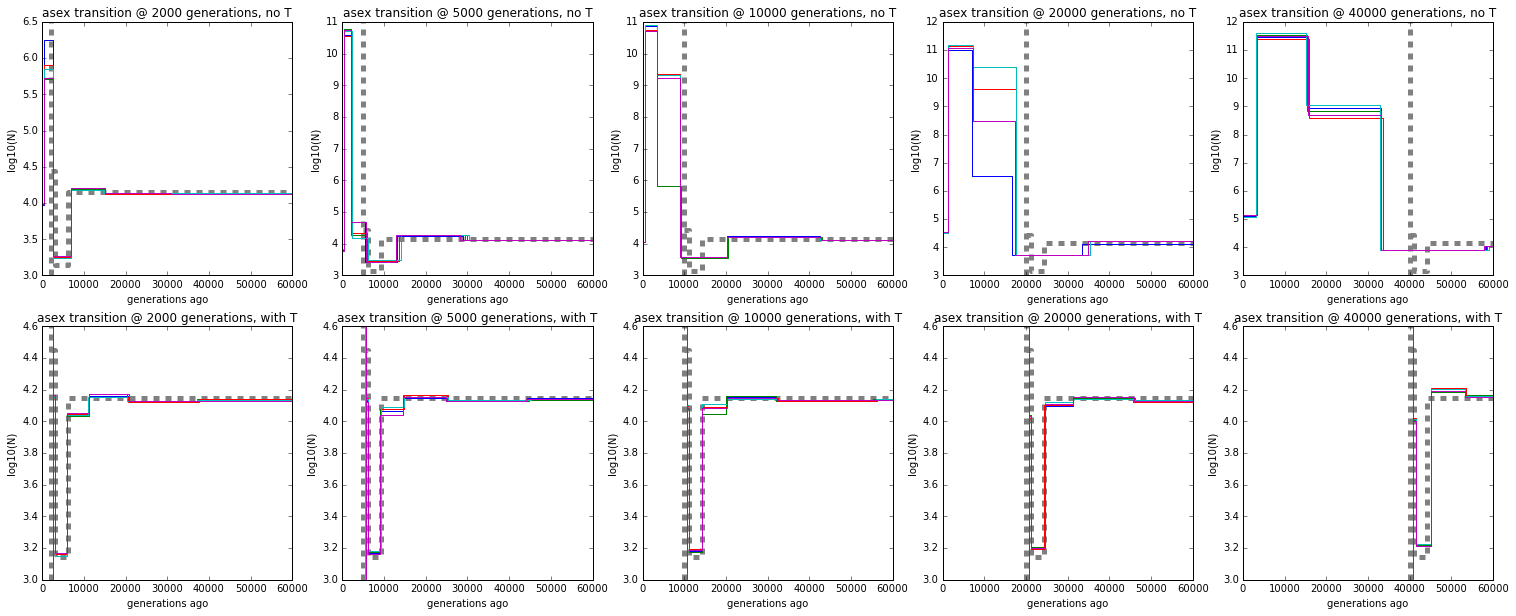

In [22]:
###### plot the std psmc data

fig, axes = plt.subplots(nrows=2,ncols=len(asexGens), figsize = (26,10))
for colIdx, asexGen in enumerate(asexGens):
    # first row: no T
    datp = stddat.loc[(stddat['asex'] == asexGen) & (np.isnan(stddat['divtime'])),:]
    axis = axes[0, colIdx]
    plot_psmc(axis, trueTs, trueNs, asexGen, color='gray', lw=5, ls='dashed')
    for rowIdx in xrange(datp.shape[0]):
        maxi = int(datp.ix[rowIdx,'maxi'])
        ts = datp.ix[rowIdx,'t0':('t{}'.format(maxi))]
        lambdas = datp.ix[rowIdx, 'lambda0':('lambda{}'.format(maxi))]
        divtime = datp.ix[rowIdx, 'divtime']
        if np.isnan(divtime):
            divtime = None
        plot_psmc(axis, ts, lambdas, divtime, maxt = 60000)
        axis.set_title('asex transition @ {} generations, no T'.format(asexGen))
        axis.set_xlabel('generations ago')
        axis.set_ylabel('log10(N)')
    # second row: T
    datp = stddat.loc[(stddat['asex'] == asexGen) & (~np.isnan(stddat['divtime'])),:]
    axis = axes[1, colIdx]
    plot_psmc(axis, trueTs, trueNs, asexGen, color='gray', lw=5, ls='dashed')
    for rowIdx in xrange(datp.shape[0]):
        maxi = int(datp.ix[rowIdx,'maxi'])
        ts = datp.ix[rowIdx,'t0':('t{}'.format(maxi))]
        lambdas = datp.ix[rowIdx, 'lambda0':('lambda{}'.format(maxi))]
        divtime = datp.ix[rowIdx, 'divtime']
        if np.isnan(divtime):
            divtime = None
        plot_psmc(axis, ts, lambdas, divtime, maxt = 60000)
        # add true divergence time
        #axis.axvline(asexGen, color = 'gray', lw = 3, ls = 'dashed')
        axis.set_title('asex transition @ {} generations, with T'.format(asexGen))
        axis.set_xlabel('generations ago')
        axis.set_ylabel('log10(N)')

**Figure description:** Divergence time and demographic inference from simulated diploid asexual genome data. The demographic history (i.e., historical population size trajectory) of the sexual ancestor is the "standard" PSMC simulation described above, shown with the dashed gray line. Each column shows results of a diploid asexual lineage that transitioned from a diploid sexual ancestor at some point in the past, which increases moving from the first to last column. This transition time is marked with a vertical dashed gray line.

In each panel, the replicate simulations are different colored lines. The top row shows the past that is inferred when the `-T` parameter is disabled, the default behavior. In this case PSMC infers an astronomically large population size during the period of asexual reproduction. The bottom row shows the same simulations analyzed with the asexual divergence `-T` parameter enabled. In these figures, the inferred divergence times are the colored vertical lines.

It is very encouraging to see that (this particular) variable-population-size history does not affect the inference of the sex-to-asex transition time and that the population size history is still recoverable.


Next: simulate triploid data, with and without variable population size history, "diploidize" the genotypes, and run PSMC.

### A note: information in polymorphism density vs genotype / SFS

The diploid PSMC takes into account only the positions of the polymorphic positions; it ignores the particular genotypes. It is encouraging that the diploid PSMC model seems to accurately infer the sex-to-asex transition time. For a hypothetical *diploid* asexual species, the only information about the Meselson effect contained in a single genome is in the spacing of polymorphisms.

For a triploid asexual species, there is also a huge amount of information in genotypes, which is the (unfolded) site-frequency spectrum of the polymorphisms. (By genotype, I mean the count of 1 or 2 derived allele copies at a polymorphic site. They would be established by polarizing against the *P. estuarinas* outgroup.) Consider the following: in a sexual panmictic population with constant population size $N$, the expected number of singletons in a sample of size $n=3$ is $\theta$, and the expected number of doubletons is $\theta/2$, where $\theta = 4N\mu$.

If a triploid asexual lineage was derived from three sexual haplotypes at time $T$ in the past (measured in units of $2N$ generations), then (due to the Meselson effect), any mutations that occurred during that interval $[0,T)$ of asexual reproduction will be present in only one copy in the lineage's genome. Thus apomictic asexual reproduction increases the expected number of singletons but not the number of doubletons.

It's straightforward to work out an estimator for this time $T$ based on the ratio of singleton vs. doubleton genotypes in the genome. The additional number of singletons expected due to the Meselson effect is $3\theta T/2$, so the total number of singletons expected is $\theta + 3\theta T/2 = \frac{2\theta + 3\theta T}{2}.$ The expected number of doubletons is still $\theta/2$, so the expected total number polymorphisms is
$\frac{3\theta+3\theta T}{2}$. The expected fraction of singleton genotypes is thus

$$
R = \frac{2+3T}{3+3T},
$$
which gives the estimator

$$
\hat{T} = \frac{3\hat{R}-2}{3(1-\hat{R})},
$$
where $\hat{R}$ is the observed fraction of polymorphic sites that are singleton genotypes. This estimator works well for simulated data but relies heavily on the assumption that the sexual ancestral population had a constant size. This estimator could be extended to any demographic history of the sexual ancestor, so long as it is possible to calculate the site-frequency spectrum for that demographic history. (There are methods of doing this.)

But generally speaking, it will be impossible to disentangle changes in the sexual ancestor's population size from the timing of the sex-to-asex transition time using only the genome-wide SFS (i.e., using this estimator). However, it may be possible to practically rule out demographic history as a plausible explanation if the observed value of $\hat{R}$ is extreme enough.

A fully-specified triploid PSMC-style model with a $T$ parameter built into the model would take full advantage of the information contained in both the spacing of polymorphic sites and the genotype frequency spectrum. I am confident that this model would have excellent power to determine the sex-to-asex transition time.

# triploid data with constant N

In [23]:
# simulate triploid data

# these are the same parameters as the constant-N simulations before,
# but now simulating triploid data with ms

mu = 1.5e-8  # mutation rate
# simulate triploid data
r = 1.0e-8  # recombination rate
N = 10000  # diploid population size in the sexual ancestor
chromLength = int(1e7)  # 10 Mbp per chromosome
numChromosomes = 100  # simulate 100 chromosomes per replicate

In [24]:
# scaled parameters for entire chromosomes
rho = 4*N*r*chromLength
theta = 4*N*mu*chromLength

In [25]:
# the different transition times to test
asexGens = np.array([2000, 5000, 10000, 20000, 40000])
asexGensRescaled = asexGens / (2.0*N)  # rescaled by 2*N

In [26]:
# generate ms commands (but using scrm instead of ms)
# scrm: http://scrm.github.io/ 

datadir = "triploidconstant"

initialT = 0.5

trcNresultsFilenames = []

msCmds = open('sim_ms_commands_constant_triploid.txt', 'w')
for asexGen in asexGensRescaled:
    for rep in xrange(1, numReps+1):
        filename = "{}/sim_data_t{}_rho{}_asex{}_triploid_rep{}".format(datadir, theta, rho, asexGen, rep)
        msCmd = "scrm 3 {numChroms} -t {theta} -r {rho} {chromLen} | ./add_asex.py - {asexGen} --triploid > {filename}".format(numChroms = numChromosomes,
                                                                   theta = theta, rho = rho,
                                                                   chromLen = chromLength, asexGen = asexGen,
                                                                   filename = filename)
        psmcfaFilename = filename + '.psmc'
        ms2psmcfaCmd = './ms2psmcfa.py {} > {}'.format(filename, psmcfaFilename)
        resultsFilename = "{}/results_t{}_rho{}_asex{}_triploid_rep{}".format(datadir, theta, rho, asexGen, rep)
        resultsFilenameT = "{}/results_t{}_rho{}_asex{}_triploid_rep{}_T".format(datadir, theta, rho, asexGen, rep)
        psmcCmd = 'psmc {} > {}'.format(psmcfaFilename, resultsFilename)
        psmcCmdT = 'psmc {} -T {} > {}'.format(psmcfaFilename, initialT, resultsFilenameT)
        wholeCmd = '{} && {} && {} && {}'.format(msCmd, ms2psmcfaCmd, psmcCmd, psmcCmdT)
        msCmds.write(wholeCmd+'\n')
# control runs with constant size and no history of asex
for rep in xrange(1,numReps+1):
    filename = "{}/sim_data_t{}_rho{}_no_asex_triploid_rep{}".format(datadir, theta, rho, rep)
    msCmd = "scrm 3 {numChroms} -t {theta} -r {rho} {chromLen} > {filename}".format(numChroms = numChromosomes,
                                                               theta = theta, rho = rho,
                                                               chromLen = chromLength,
                                                               filename = filename)
    psmcfaFilename = filename + '.psmc'
    ms2psmcfaCmd = './ms2psmcfa.py {} > {}'.format(filename, psmcfaFilename)
    resultsFilename = "{}/results_t{}_rho{}_no_asex_triploid_rep{}".format(datadir, theta, rho, rep)
    resultsFilenameT = "{}/results_t{}_rho{}_no_asex_triploid_rep{}_T".format(datadir, theta, rho, rep)
    psmcCmd = 'psmc {} > {}'.format(psmcfaFilename, resultsFilename)
    psmcCmdT = 'psmc {} -T {} > {}'.format(psmcfaFilename, initialT, resultsFilenameT)
    wholeCmd = '{} && {} && {} && {}'.format(msCmd, ms2psmcfaCmd, psmcCmd, psmcCmdT)
    msCmds.write(wholeCmd+'\n')
msCmds.close()

In [27]:
%%bash

head -n 1 'sim_ms_commands_constant_triploid.txt'
tail -n 1 'sim_ms_commands_constant_triploid.txt'

scrm 3 100 -t 6000.0 -r 4000.0 10000000 | ./add_asex.py - 0.1 --triploid > triploidconstant/sim_data_t6000.0_rho4000.0_asex0.1_triploid_rep1 && ./ms2psmcfa.py triploidconstant/sim_data_t6000.0_rho4000.0_asex0.1_triploid_rep1 > triploidconstant/sim_data_t6000.0_rho4000.0_asex0.1_triploid_rep1.psmc && psmc triploidconstant/sim_data_t6000.0_rho4000.0_asex0.1_triploid_rep1.psmc > triploidconstant/results_t6000.0_rho4000.0_asex0.1_triploid_rep1 && psmc triploidconstant/sim_data_t6000.0_rho4000.0_asex0.1_triploid_rep1.psmc -T 0.5 > triploidconstant/results_t6000.0_rho4000.0_asex0.1_triploid_rep1_T
scrm 3 100 -t 6000.0 -r 4000.0 10000000 > triploidconstant/sim_data_t6000.0_rho4000.0_no_asex_triploid_rep5 && ./ms2psmcfa.py triploidconstant/sim_data_t6000.0_rho4000.0_no_asex_triploid_rep5 > triploidconstant/sim_data_t6000.0_rho4000.0_no_asex_triploid_rep5.psmc && psmc triploidconstant/sim_data_t6000.0_rho4000.0_no_asex_triploid_rep5.psmc > triploidconstant/results_t6000.0_rho4000.0_no_asex_trip

In [28]:
%%bash

#scp sim_ms_commands_constant_triploid.txt peter@ammodramus:/tmp/

In [29]:
trcNrows = {}
for asexGenRescaled, asexGen in zip(asexGensRescaled, asexGens):
    for rep in xrange(1, numReps+1):
        resultsFilename = "{}/results_t{}_rho{}_asex{}_triploid_rep{}".format(datadir, theta, rho, asexGenRescaled, rep)
        resultsFilenameT = "{}/results_t{}_rho{}_asex{}_triploid_rep{}_T".format(datadir, theta, rho, asexGenRescaled, rep)
        
        index = 'asex{}_rep{}'.format(asexGen, rep)
        results = read_psmc_results(resultsFilename)
        results['asex'] = asexGen
        results['rep'] = rep
        trcNrows[index] = results
        
        index = 'asex{}_rep{}_T'.format(asexGen, rep)
        results = read_psmc_results(resultsFilenameT)
        results['asex'] = asexGen
        results['rep'] = rep
        trcNrows[index] = results
        
# control runs with constant size and no history of asex
for rep in xrange(1,numReps+1):
    resultsFilename = "{}/results_t{}_rho{}_no_asex_triploid_rep{}".format(datadir, theta, rho, rep)
    resultsFilenameT = "{}/results_t{}_rho{}_no_asex_triploid_rep{}_T".format(datadir, theta, rho, rep)
    
    index = 'no_asex_rep{}'.format(rep)
    results = read_psmc_results(resultsFilename)
    results['asex'] = None
    results['rep'] = rep
    trcNrows[index] = results
    
    index = 'no_asex_rep{}_T'.format(rep)
    results = read_psmc_results(resultsFilenameT)
    results['asex'] = None
    results['rep'] = rep
    trcNrows[index] = results


In [30]:
# make a dataframe for standard (var-N) psmc data

trcNdat = pd.DataFrame.from_dict(trcNrows, orient = 'index')
maxi = int(trcNdat['maxi'].max())
newCols = ['asex', 'rep', 'theta', 'rho', 'divtime']
newCols.extend(['lambda'+str(i) for i in xrange(0,maxi+1)])
newCols.extend(['t'+str(i) for i in xrange(0,maxi+1)])
newCols.append('maxi')
trcNdat = trcNdat[newCols]

In [31]:
# rescaling the population sizes and times in the standard (var-N) simulations

binSize = 100  # we binned the bp's by 100 in the input to PSMC

trcNdat['lambda0'] = trcNdat['theta'] / (4.0*mu) / binSize

trcNdat['divtime'] = 2.0*trcNdat['lambda0'] * trcNdat['divtime']

for i in xrange(1, maxi+1):
    colLam = 'lambda'+str(i)
    colT = 't'+str(i)
    trcNdat[colLam] = trcNdat['lambda0'] * trcNdat[colLam]
    trcNdat[colT] = 2.0*trcNdat['lambda0'] * trcNdat[colT]

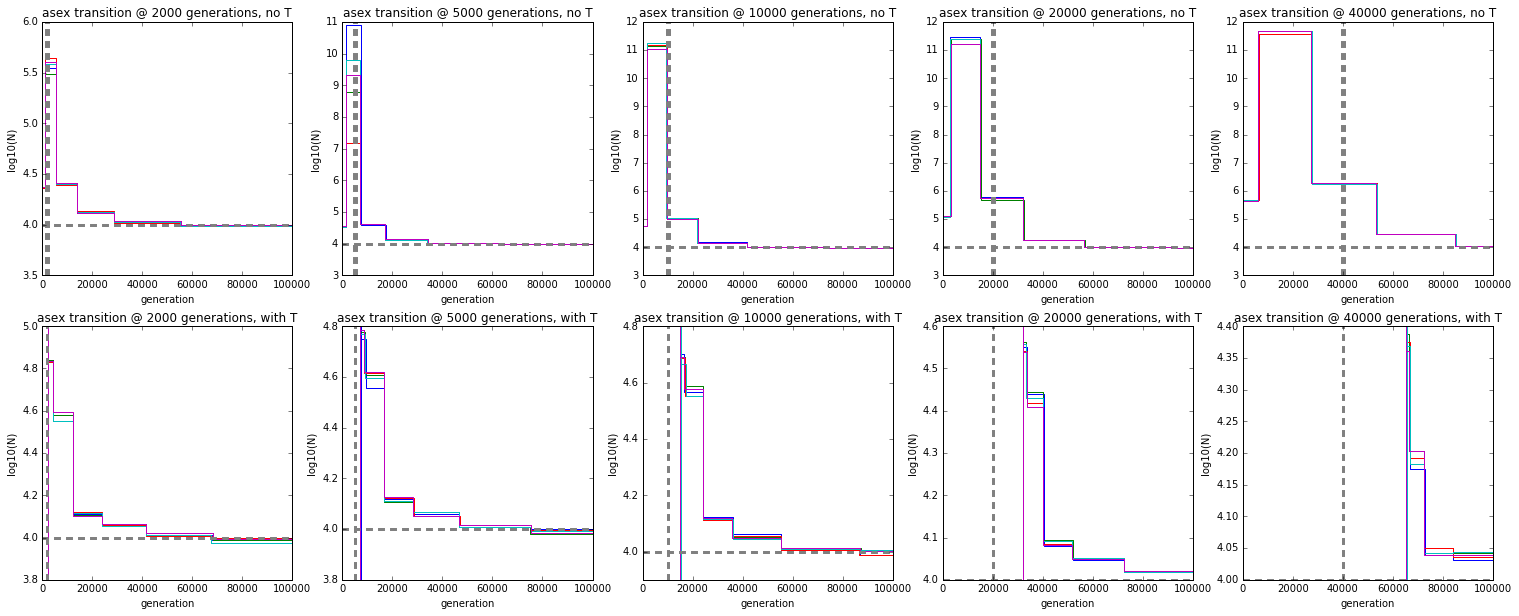

In [32]:
# plot the triploid constant-N data

fig, axes = plt.subplots(nrows=2,ncols=len(asexGens), figsize = (26,10))
for colIdx, asexGen in enumerate(asexGens):
    # first row: no T
    datp = trcNdat.loc[(trcNdat['asex'] == asexGen) & (np.isnan(trcNdat['divtime'])),:]
    axis = axes[0, colIdx]
    for rowIdx in xrange(datp.shape[0]):
        maxi = int(datp.ix[rowIdx,'maxi'])
        ts = datp.ix[rowIdx,'t0':('t{}'.format(maxi))]
        lambdas = datp.ix[rowIdx, 'lambda0':('lambda{}'.format(maxi))]
        divtime = datp.ix[rowIdx, 'divtime']
        if np.isnan(divtime):
            divtime = None
        plot_psmc(axis, ts, lambdas, divtime, maxt = 100000)
        axis.axvline(asexGen, color = 'gray', lw = 5, ls = 'dashed')
        axis.axhline(np.log10(N), color = 'gray', lw = 3, ls = 'dashed')
        axis.set_title('asex transition @ {} generations, no T'.format(asexGen))
        axis.set_xlabel('generation')
        axis.set_ylabel('log10(N)')
    # second row: with T
    datp = trcNdat.loc[(trcNdat['asex'] == asexGen) & (~np.isnan(trcNdat['divtime'])),:]
    axis = axes[1, colIdx]
    for rowIdx in xrange(datp.shape[0]):
        maxi = int(datp.ix[rowIdx,'maxi'])
        ts = datp.ix[rowIdx,'t0':('t{}'.format(maxi))]
        lambdas = datp.ix[rowIdx, 'lambda0':('lambda{}'.format(maxi))]
        divtime = datp.ix[rowIdx, 'divtime']
        if np.isnan(divtime):
            divtime = None
        plot_psmc(axis, ts, lambdas, divtime, maxt = 100000)
        # add true divergence time
        axis.axvline(asexGen, color = 'gray', lw = 3, ls = 'dashed')
        axis.axhline(np.log10(N), color = 'gray', lw = 3, ls = 'dashed')
        axis.set_title('asex transition @ {} generations, with T'.format(asexGen))
        axis.set_xlabel('generation')
        axis.set_ylabel('log10(N)')
        

**Figure summary:** Inferred sex-to-asex transition times from "diploidized" triploid data. Top row shows parameters inferred when the `-T` transition parameter is disabled, bottom row when `-T` is enabled. PSMC takes as its input the spacing of polymorphic positions in the genome. With three haploid genomes targeted by mutations during the asexual part of the lineage's ancestry, there are more of these Meselson-effect mutations, which is apparently interpreted as a longer period of asexual ancestry.

Quantitatively these inferences are biased towards a longer period of asexual ancestry, but qualitatively the PSMC can still determine whether the sex-to-asex transition was relatively recent or ancient. The precise measurement of these parameters depends on knowing the per-generation, per-base mutation rate, which is unknown in *Potamopyrgus*, so our conclusions will necessarily be qualitative anyway. Is it then worth it to develop a triploid versoin of PSMC with the divergence parameter incorporated and modeled appropriately? One reason to make the full model is to get a better sense of what the diploid sexual ancestor's history might have been.

**Control (sexual) triploid data**. Testing whether triploidy itself can cause a signal of asexual history in sexually reproducing organisms using PSMC. When the `-T` parameter is enabled, the inferred value of the sex-to-asex transition time is $T=0$ for every replicate, indicating that triploidy alone does not cause PSMC to infer asexuality. (To compare to previous figures: the lower panel here would have vertical lines along the vertical axis [$x=0$], indicating no inferred asexual history.) The inferred demographic history of the population is incorrect, however. The true (constant) population size is $N = 10^4$, but since PSMC is modeled under the assumption of diploid data, it infers recent growth in the population owing to the fact that the additional lineage in the initial part of the gene genealogy yields more polymorphic sites in this recent period.

# Recent exponential growth

### diploids

In [33]:
N0 = 1000000
N1 = 5000
Tgrowth = 100

rescaledN1 = N1 / (4.0*N0)
rescaledTgrowth = Tgrowth / (4.0*N0)
growthRate = np.log(float(N0)/N1) / rescaledTgrowth

mu = 1.5e-8
r = 1.0e-8  # recombination rate
chromLength = int(1e7)  # 10 Mbp per chromosome
numChromosomes = 100  # simulate 100 chromosomes per replicate

# scaled parameters for entire chromosomes
rho = 4*N0*r*chromLength
theta = 4*N0*mu*chromLength

numReps = 5

# the different transition times to test
asexGens = np.array([2000, 5000, 10000, 20000, 40000])
asexGensRescaled = asexGens / (2.0*N0)  # rescaled by 2*N

trueTs = [0, 100,100000]
trueNs = [1000000, 5000,5000]

In [34]:
datadir = "diploidexp"

initialT = 0.5

msCmds = open('sim_ms_commands_diploid_exp.txt', 'w')
for asexGen in asexGensRescaled:
    for rep in xrange(1, numReps+1):
        filename = "{}/sim_data_t{}_rho{}_asex{}_diploid_exp_rep{}".format(datadir, theta, rho, asexGen, rep)
        msCmd = "scrm 2 {numChroms} -t {theta} -r {rho} {chromLen} -eG 0 {growthRate} -eN {rescaledTgrowth} {rescaledN1}| ./add_asex.py - {asexGen} > {filename}".format(numChroms = numChromosomes,
                                                                   theta = theta, rho = rho,
                                                                   chromLen = chromLength, growthRate = growthRate,
                                                                   rescaledTgrowth = rescaledTgrowth, rescaledN1 = rescaledN1,
                                                                   asexGen = asexGen, filename = filename)
        psmcfaFilename = filename + '.psmc'
        ms2psmcfaCmd = './ms2psmcfa.py {} > {}'.format(filename, psmcfaFilename)
        resultsFilename = "{}/results_t{}_rho{}_asex{}_diploid_exp_rep{}".format(datadir, theta, rho, asexGen, rep)
        resultsFilenameT = "{}/results_t{}_rho{}_asex{}_diploid_exp_rep{}_T".format(datadir, theta, rho, asexGen, rep)
        psmcCmd = 'psmc {} > {}'.format(psmcfaFilename, resultsFilename)
        psmcCmdT = 'psmc {} -T {} > {}'.format(psmcfaFilename, initialT, resultsFilenameT)
        wholeCmd = '{} && {} && {} && {}'.format(msCmd, ms2psmcfaCmd, psmcCmd, psmcCmdT)
        msCmds.write(wholeCmd+'\n')
# control runs with constant size and no history of asex
for rep in xrange(1,numReps+1):
    filename = "{}/sim_data_t{}_rho{}_no_asex_diploid_exp_rep{}".format(datadir, theta, rho, rep)
    msCmd = "scrm 2 {numChroms} -t {theta} -r {rho} {chromLen} -eG 0 {growthRate} -eN {rescaledTgrowth} {rescaledN1} > {filename}".format(numChroms = numChromosomes,
                                                               theta = theta, rho = rho,
                                                               chromLen = chromLength, growthRate = growthRate,
                                                               rescaledTgrowth = rescaledTgrowth, rescaledN1 = rescaledN1,
                                                               filename = filename)
    psmcfaFilename = filename + '.psmc'
    ms2psmcfaCmd = './ms2psmcfa.py {} > {}'.format(filename, psmcfaFilename)
    resultsFilename = "{}/results_t{}_rho{}_no_asex_diploid_exp_rep{}".format(datadir, theta, rho, rep)
    resultsFilenameT = "{}/results_t{}_rho{}_no_asex_diploid_exp_rep{}_T".format(datadir, theta, rho, rep)
    psmcCmd = 'psmc {} > {}'.format(psmcfaFilename, resultsFilename)
    psmcCmdT = 'psmc {} -T {} > {}'.format(psmcfaFilename, initialT, resultsFilenameT)
    wholeCmd = '{} && {} && {} && {}'.format(msCmd, ms2psmcfaCmd, psmcCmd, psmcCmdT)
    msCmds.write(wholeCmd+'\n')
msCmds.close()

In [35]:
%%bash

head -n 1 sim_ms_commands_diploid_exp.txt
tail -n 1 sim_ms_commands_diploid_exp.txt

scrm 2 100 -t 600000.0 -r 400000.0 10000000 -eG 0 211932.694662 -eN 2.5e-05 0.00125| ./add_asex.py - 0.001 > diploidexp/sim_data_t600000.0_rho400000.0_asex0.001_diploid_exp_rep1 && ./ms2psmcfa.py diploidexp/sim_data_t600000.0_rho400000.0_asex0.001_diploid_exp_rep1 > diploidexp/sim_data_t600000.0_rho400000.0_asex0.001_diploid_exp_rep1.psmc && psmc diploidexp/sim_data_t600000.0_rho400000.0_asex0.001_diploid_exp_rep1.psmc > diploidexp/results_t600000.0_rho400000.0_asex0.001_diploid_exp_rep1 && psmc diploidexp/sim_data_t600000.0_rho400000.0_asex0.001_diploid_exp_rep1.psmc -T 0.5 > diploidexp/results_t600000.0_rho400000.0_asex0.001_diploid_exp_rep1_T
scrm 2 100 -t 600000.0 -r 400000.0 10000000 -eG 0 211932.694662 -eN 2.5e-05 0.00125 > diploidexp/sim_data_t600000.0_rho400000.0_no_asex_diploid_exp_rep5 && ./ms2psmcfa.py diploidexp/sim_data_t600000.0_rho400000.0_no_asex_diploid_exp_rep5 > diploidexp/sim_data_t600000.0_rho400000.0_no_asex_diploid_exp_rep5.psmc && psmc diploidexp/sim_data_t60000

In [36]:
%%bash

#scp sim_ms_commands_diploid_exp.txt peter@ammodramus:/tmp/

In [37]:
dipExpRows = {}
for asexGenRescaled, asexGen in zip(asexGensRescaled, asexGens):
    for rep in xrange(1, numReps+1):
        resultsFilename = "{}/results_t{}_rho{}_asex{}_diploid_exp_rep{}".format(datadir, theta, rho, asexGenRescaled, rep)
        resultsFilenameT = "{}/results_t{}_rho{}_asex{}_diploid_exp_rep{}_T".format(datadir, theta, rho, asexGenRescaled, rep)
        
        index = 'asex{}_rep{}'.format(asexGen, rep)
        results = read_psmc_results(resultsFilename)
        results['asex'] = asexGen
        results['rep'] = rep
        dipExpRows[index] = results
        
        index = 'asex{}_rep{}_T'.format(asexGen, rep)
        results = read_psmc_results(resultsFilenameT)
        results['asex'] = asexGen
        results['rep'] = rep
        dipExpRows[index] = results
        
# control runs with constant size and no history of asex
for rep in xrange(1,numReps+1):
    resultsFilename = "{}/results_t{}_rho{}_no_asex_diploid_exp_rep{}".format(datadir, theta, rho, rep)
    resultsFilenameT = "{}/results_t{}_rho{}_no_asex_diploid_exp_rep{}_T".format(datadir, theta, rho, rep)
    
    index = 'no_asex_rep{}'.format(rep)
    results = read_psmc_results(resultsFilename)
    results['asex'] = None
    results['rep'] = rep
    dipExpRows[index] = results
    
    index = 'no_asex_rep{}_T'.format(rep)
    results = read_psmc_results(resultsFilenameT)
    results['asex'] = None
    results['rep'] = rep
    dipExpRows[index] = results

# make a dataframe for standard (var-N) psmc data

dipExpDat = pd.DataFrame.from_dict(dipExpRows, orient = 'index')
maxi = int(dipExpDat['maxi'].max())
newCols = ['asex', 'rep', 'theta', 'rho', 'divtime']
newCols.extend(['lambda'+str(i) for i in xrange(0,maxi+1)])
newCols.extend(['t'+str(i) for i in xrange(0,maxi+1)])
newCols.append('maxi')
dipExpDat = dipExpDat[newCols]

# rescaling input

binSize = 100  # we binned the bp's by 100 in the input to PSMC

dipExpDat['lambda0'] = dipExpDat['theta'] / (4.0*mu) / binSize

dipExpDat['divtime'] = 2.0*dipExpDat['lambda0'] * dipExpDat['divtime']

for i in xrange(1, maxi+1):
    colLam = 'lambda'+str(i)
    colT = 't'+str(i)
    dipExpDat[colLam] = dipExpDat['lambda0'] * dipExpDat[colLam]
    dipExpDat[colT] = 2.0*dipExpDat['lambda0'] * dipExpDat[colT]

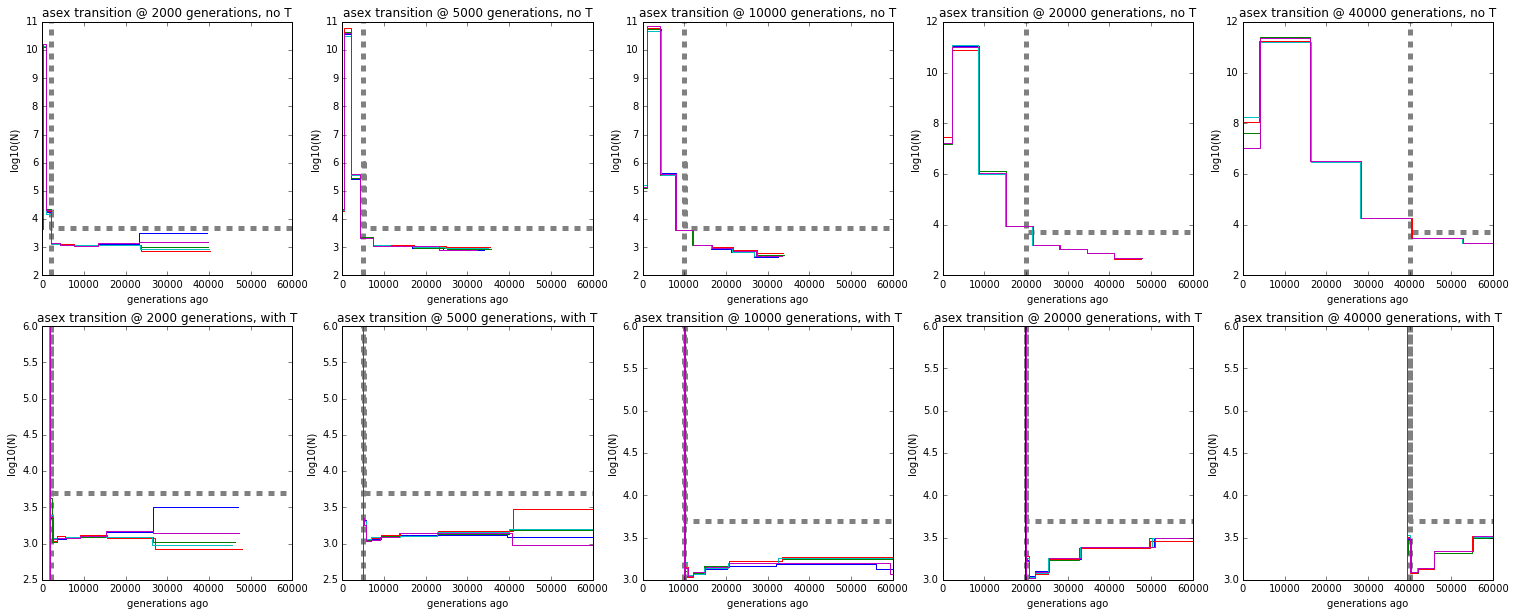

In [38]:
###### plot the diploid exponential data

fig, axes = plt.subplots(nrows=2,ncols=len(asexGens), figsize = (26,10))
for colIdx, asexGen in enumerate(asexGens):
    # first row: no T
    datp = dipExpDat.loc[(dipExpDat['asex'] == asexGen) & (np.isnan(dipExpDat['divtime'])),:]
    axis = axes[0, colIdx]
    plot_psmc(axis, trueTs, trueNs, asexGen, color='gray', lw=5, ls='dashed')
    for rowIdx in xrange(datp.shape[0]):
        maxi = int(datp.ix[rowIdx,'maxi'])
        ts = datp.ix[rowIdx,'t0':('t{}'.format(maxi))]
        lambdas = datp.ix[rowIdx, 'lambda0':('lambda{}'.format(maxi))]
        divtime = datp.ix[rowIdx, 'divtime']
        if np.isnan(divtime):
            divtime = None
        plot_psmc(axis, ts, lambdas, divtime, maxt = 60000)
        axis.set_title('asex transition @ {} generations, no T'.format(asexGen))
        axis.set_xlabel('generations ago')
        axis.set_ylabel('log10(N)')
    # second row: T
    datp = dipExpDat.loc[(dipExpDat['asex'] == asexGen) & (~np.isnan(dipExpDat['divtime'])),:]
    axis = axes[1, colIdx]
    plot_psmc(axis, trueTs, trueNs, asexGen, color='gray', lw=5, ls='dashed')
    for rowIdx in xrange(datp.shape[0]):
        maxi = int(datp.ix[rowIdx,'maxi'])
        ts = datp.ix[rowIdx,'t0':('t{}'.format(maxi))]
        lambdas = datp.ix[rowIdx, 'lambda0':('lambda{}'.format(maxi))]
        divtime = datp.ix[rowIdx, 'divtime']
        if np.isnan(divtime):
            divtime = None
        plot_psmc(axis, ts, lambdas, divtime, maxt = 60000)
        # add true divergence time
        axis.set_title('asex transition @ {} generations, with T'.format(asexGen))
        axis.set_xlabel('generations ago')
        axis.set_ylabel('log10(N)')

PSMC is bad at detecting recent population changes, and huge expansion in the last 100 generations is definitely not something that it is going to infer well. Here, this recent expansion gives PSMC trouble estimating the population size after the sex-to-asex transition, but the timing of the sex-to-asex transition is still inferred accurately. This is encouraging: recent demography doesn't seem to bias the estimation of the sex-to-asex transition time.

### now triploids with recent exponential growth

In [39]:
# now triploids with exponential growth

datadir = "triploidexp"

initialT = 0.5

msCmds = open('sim_ms_commands_triploid_exp.txt', 'w')
for asexGen in asexGensRescaled:
    for rep in xrange(1, numReps+1):
        filename = "{}/sim_data_t{}_rho{}_asex{}_triploid_exp_rep{}".format(datadir, theta, rho, asexGen, rep)
        msCmd = "scrm 3 {numChroms} -t {theta} -r {rho} {chromLen} -eG 0 {growthRate} -eN {rescaledTgrowth} {rescaledN1} | ./add_asex.py - {asexGen} --triploid > {filename}".format(numChroms = numChromosomes,
                                                                   theta = theta, rho = rho,
                                                                   chromLen = chromLength, growthRate = growthRate,
                                                                   rescaledTgrowth = rescaledTgrowth, rescaledN1 = rescaledN1,
                                                                   asexGen = asexGen, filename = filename)
        psmcfaFilename = filename + '.psmc'
        ms2psmcfaCmd = './ms2psmcfa.py {} > {}'.format(filename, psmcfaFilename)
        resultsFilename = "{}/results_t{}_rho{}_asex{}_triploid_exp_rep{}".format(datadir, theta, rho, asexGen, rep)
        resultsFilenameT = "{}/results_t{}_rho{}_asex{}_triploid_exp_rep{}_T".format(datadir, theta, rho, asexGen, rep)
        psmcCmd = 'psmc {} > {}'.format(psmcfaFilename, resultsFilename)
        psmcCmdT = 'psmc {} -T {} > {}'.format(psmcfaFilename, initialT, resultsFilenameT)
        wholeCmd = '{} && {} && {} && {}'.format(msCmd, ms2psmcfaCmd, psmcCmd, psmcCmdT)
        msCmds.write(wholeCmd+'\n')
# control runs with constant size and no history of asex
for rep in xrange(1,numReps+1):
    filename = "{}/sim_data_t{}_rho{}_no_asex_triploid_exp_rep{}".format(datadir, theta, rho, rep)
    msCmd = "scrm 3 {numChroms} -t {theta} -r {rho} {chromLen} -eG 0 {growthRate} -eN {rescaledTgrowth} {rescaledN1} > {filename}".format(numChroms = numChromosomes,
                                                               theta = theta, rho = rho,
                                                               chromLen = chromLength, growthRate = growthRate,
                                                               rescaledTgrowth = rescaledTgrowth, rescaledN1 = rescaledN1,
                                                               filename = filename)
    psmcfaFilename = filename + '.psmc'
    ms2psmcfaCmd = './ms2psmcfa.py {} > {}'.format(filename, psmcfaFilename)
    resultsFilename = "{}/results_t{}_rho{}_no_asex_triploid_exp_rep{}".format(datadir, theta, rho, rep)
    resultsFilenameT = "{}/results_t{}_rho{}_no_asex_triploid_exp_rep{}_T".format(datadir, theta, rho, rep)
    psmcCmd = 'psmc {} > {}'.format(psmcfaFilename, resultsFilename)
    psmcCmdT = 'psmc {} -T {} > {}'.format(psmcfaFilename, initialT, resultsFilenameT)
    wholeCmd = '{} && {} && {} && {}'.format(msCmd, ms2psmcfaCmd, psmcCmd, psmcCmdT)
    msCmds.write(wholeCmd+'\n')
msCmds.close()

In [40]:
%%bash

head -n 1 sim_ms_commands_triploid_exp.txt
tail -n 1 sim_ms_commands_triploid_exp.txt

scrm 3 100 -t 600000.0 -r 400000.0 10000000 -eG 0 211932.694662 -eN 2.5e-05 0.00125 | ./add_asex.py - 0.001 --triploid > triploidexp/sim_data_t600000.0_rho400000.0_asex0.001_triploid_exp_rep1 && ./ms2psmcfa.py triploidexp/sim_data_t600000.0_rho400000.0_asex0.001_triploid_exp_rep1 > triploidexp/sim_data_t600000.0_rho400000.0_asex0.001_triploid_exp_rep1.psmc && psmc triploidexp/sim_data_t600000.0_rho400000.0_asex0.001_triploid_exp_rep1.psmc > triploidexp/results_t600000.0_rho400000.0_asex0.001_triploid_exp_rep1 && psmc triploidexp/sim_data_t600000.0_rho400000.0_asex0.001_triploid_exp_rep1.psmc -T 0.5 > triploidexp/results_t600000.0_rho400000.0_asex0.001_triploid_exp_rep1_T
scrm 3 100 -t 600000.0 -r 400000.0 10000000 -eG 0 211932.694662 -eN 2.5e-05 0.00125 > triploidexp/sim_data_t600000.0_rho400000.0_no_asex_triploid_exp_rep5 && ./ms2psmcfa.py triploidexp/sim_data_t600000.0_rho400000.0_no_asex_triploid_exp_rep5 > triploidexp/sim_data_t600000.0_rho400000.0_no_asex_triploid_exp_rep5.psmc &&

In [41]:
%%bash

#ssh peter@ammodramus "mkdir -p /tmp/triploidexp"
#scp sim_ms_commands_triploid_exp.txt peter@ammodramus:/tmp/

Next: gene conversion, calculate number of states and estimate runtime for full triploid model, fragmentize the genome.

In [42]:
datadir = "triploidexp"

tripExpRows = {}
for asexGenRescaled, asexGen in zip(asexGensRescaled, asexGens):
    for rep in xrange(1, numReps+1):
        resultsFilename = "{}/results_t{}_rho{}_asex{}_triploid_exp_rep{}".format(datadir, theta, rho, asexGenRescaled, rep)
        resultsFilenameT = "{}/results_t{}_rho{}_asex{}_triploid_exp_rep{}_T".format(datadir, theta, rho, asexGenRescaled, rep)
        
        index = 'asex{}_rep{}'.format(asexGen, rep)
        results = read_psmc_results(resultsFilename)
        results['asex'] = asexGen
        results['rep'] = rep
        tripExpRows[index] = results
        
        index = 'asex{}_rep{}_T'.format(asexGen, rep)
        results = read_psmc_results(resultsFilenameT)
        results['asex'] = asexGen
        results['rep'] = rep
        tripExpRows[index] = results
        
# control runs with constant size and no history of asex
for rep in xrange(1,numReps+1):
    resultsFilename = "{}/results_t{}_rho{}_no_asex_triploid_exp_rep{}".format(datadir, theta, rho, rep)
    resultsFilenameT = "{}/results_t{}_rho{}_no_asex_triploid_exp_rep{}_T".format(datadir, theta, rho, rep)
    
    index = 'no_asex_rep{}'.format(rep)
    results = read_psmc_results(resultsFilename)
    results['asex'] = None
    results['rep'] = rep
    tripExpRows[index] = results
    
    index = 'no_asex_rep{}_T'.format(rep)
    results = read_psmc_results(resultsFilenameT)
    results['asex'] = None
    results['rep'] = rep
    tripExpRows[index] = results

# make a dataframe for standard (var-N) psmc data

tripExpDat = pd.DataFrame.from_dict(tripExpRows, orient = 'index')
maxi = int(tripExpDat['maxi'].max())
newCols = ['asex', 'rep', 'theta', 'rho', 'divtime']
newCols.extend(['lambda'+str(i) for i in xrange(0,maxi+1)])
newCols.extend(['t'+str(i) for i in xrange(0,maxi+1)])
newCols.append('maxi')
tripExpDat = tripExpDat[newCols]

# rescaling input

binSize = 100  # we binned the bp's by 100 in the input to PSMC

tripExpDat['lambda0'] = tripExpDat['theta'] / (4.0*mu) / binSize

tripExpDat['divtime'] = 2.0*tripExpDat['lambda0'] * tripExpDat['divtime']

for i in xrange(1, maxi+1):
    colLam = 'lambda'+str(i)
    colT = 't'+str(i)
    tripExpDat[colLam] = tripExpDat['lambda0'] * tripExpDat[colLam]
    tripExpDat[colT] = 2.0*tripExpDat['lambda0'] * tripExpDat[colT]

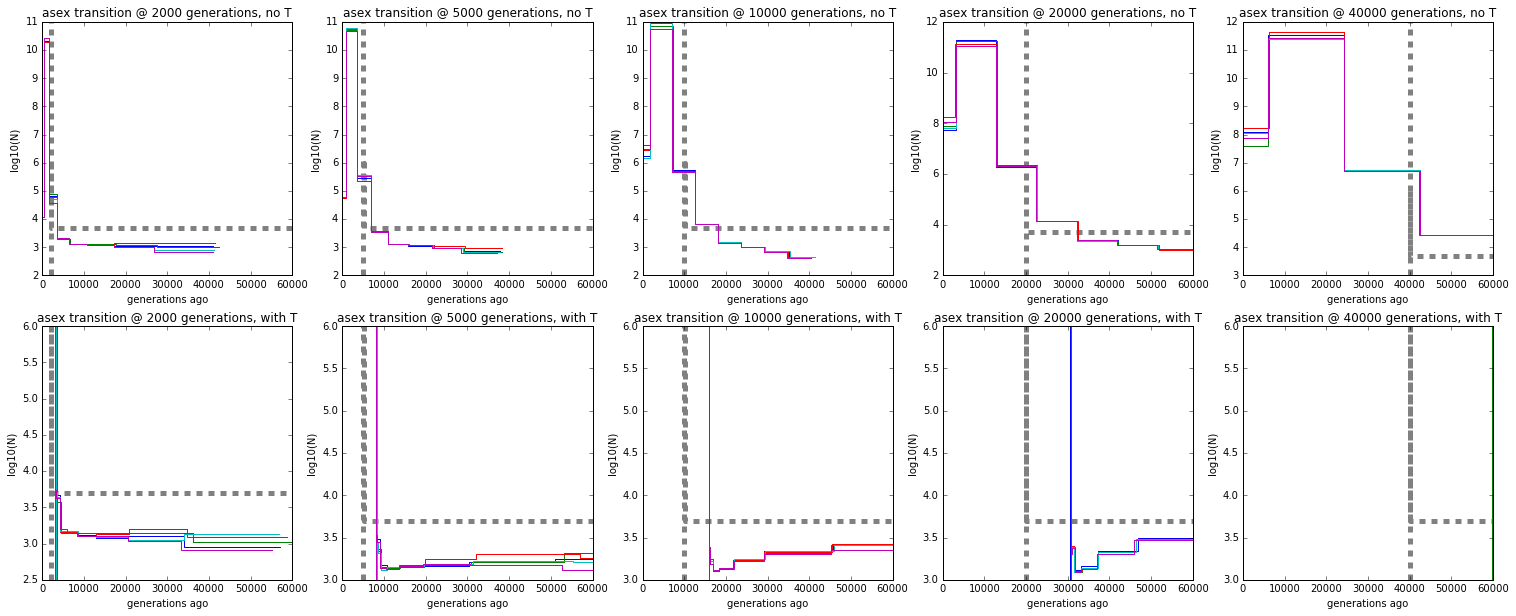

In [43]:
###### plot the triploid exponential data

fig, axes = plt.subplots(nrows=2,ncols=len(asexGens), figsize = (26,10))
for colIdx, asexGen in enumerate(asexGens):
    # first row: no T
    datp = tripExpDat.loc[(tripExpDat['asex'] == asexGen) & (np.isnan(tripExpDat['divtime'])),:]
    axis = axes[0, colIdx]
    plot_psmc(axis, trueTs, trueNs, asexGen, color='gray', lw=5, ls='dashed')
    for rowIdx in xrange(datp.shape[0]):
        maxi = int(datp.ix[rowIdx,'maxi'])
        ts = datp.ix[rowIdx,'t0':('t{}'.format(maxi))]
        lambdas = datp.ix[rowIdx, 'lambda0':('lambda{}'.format(maxi))]
        divtime = datp.ix[rowIdx, 'divtime']
        if np.isnan(divtime):
            divtime = None
        plot_psmc(axis, ts, lambdas, divtime, maxt = 60000)
        axis.set_title('asex transition @ {} generations, no T'.format(asexGen))
        axis.set_xlabel('generations ago')
        axis.set_ylabel('log10(N)')
    # second row: T
    datp = tripExpDat.loc[(tripExpDat['asex'] == asexGen) & (~np.isnan(tripExpDat['divtime'])),:]
    axis = axes[1, colIdx]
    plot_psmc(axis, trueTs, trueNs, asexGen, color='gray', lw=5, ls='dashed')
    for rowIdx in xrange(datp.shape[0]):
        maxi = int(datp.ix[rowIdx,'maxi'])
        ts = datp.ix[rowIdx,'t0':('t{}'.format(maxi))]
        lambdas = datp.ix[rowIdx, 'lambda0':('lambda{}'.format(maxi))]
        divtime = datp.ix[rowIdx, 'divtime']
        if np.isnan(divtime):
            divtime = None
        plot_psmc(axis, ts, lambdas, divtime, maxt = 60000)
        # add true divergence time
        axis.set_title('asex transition @ {} generations, with T'.format(asexGen))
        axis.set_xlabel('generations ago')
        axis.set_ylabel('log10(N)')

Besides the trouble in using triploid data when diploid data should be used, the sex-to-asex transition time is still inferred correctly, at least qualitatively. Like with the diploid data and recent exponential growth, the population size is not estimated correctly in the more distant past. Need to look into this and make sure that this is somehow expected.

**Next:** fragmentize the data, try to reconstruct, say, "standard PSMC simulation" with correct contig sizes reflecting current assembly. Also try slower, longer-term exponential growth.

# assembly- and genome-specific contig lengths

The ms command to generate their "standard simulation," from the paper:

    ms 2 100 -t 81960 -r 13560 30000000 -eN 0.01 0.05 -eN 0.0375 0.5 -eN 1.25 1

This sets $N_0 = 28000$, $\theta = 4N_0\mu = 81960$,
thus $\mu = 2.44 \times 10^{-8}$, $\rho = 4N_0r = 13560$, thus
$r = 4.04 \times 10^{-9}$.

Changes in population size:

 - at 1120 generations, $N_0 \to N_1 = 1400$
 - at 4200 generations, $N_1 \to N_2 = 14000$
 - at 140000 generations, $N_2 \to N_3 = 28000$

Again, we will add $\{2000, 5000, 10000, 20000, 40000\}$ generations of asexual reproduction and see how PSMC determines these transition times from the genome-wide signal of the Meselson effect.

In [80]:
N0 = 28000
muStd = 2.44e-8
rStd = 4.04e-9
numChroms = 100
potamoGenomeSize = int(1e9)
chromLen = potamoGenomeSize/numChroms
theta = 4*N0*muStd*chromLen
rho = 4*N0*rStd*chromLen

asexGens = np.array([2000, 5000, 10000, 20000, 40000], dtype = np.int)

trueTs = np.array([1120, 4200, 140000])
trueNs = np.array([1400,14000,28000])

In [55]:
# generate commands for std sim with assembly-specific data

stdAssemblyMsCmd = "scrm 2 {numChroms} -t {theta} -r {rho} {chromLen} -eN 0.01 0.05 -eN 0.0375 0.5 -eN 1.25 1".format(
    numChroms = numChroms, theta = theta, rho = rho, chromLen = chromLen)

datadir = "stdassemblysimdata"

contigLenFilename = '10k_new_assem_column.txt'

stdAsexGensRescaled = asexGens/(2.0*N0)

stdMsCmdsAssembly = open('sim_ms_commands_standard_assembly.txt', 'w')
for asexGen in stdAsexGensRescaled:
    for rep in xrange(1, numReps+1):
        filename = "{}/standard_assembly_sim_data_t{}_rho{}_asex{}_rep{}".format(datadir, theta, rho, asexGen, rep)
        msCmd = stdAssemblyMsCmd + ' | ./add_asex.py - {asexGen} > {filename}'.format(asexGen=asexGen, filename = filename)
        ms2psmcfaCmd = 'python contigize_ms.py {msfilename} {conLensFilename} > {msfilename}.psmc'.format(
            msfilename = filename, conLensFilename = contigLenFilename)
        psmcfilename = '{}/results_standard_assembly_t{}_rho{}_asex{}_rep{}'.format(datadir, theta, rho, asexGen, rep)
        psmcCmd = 'psmc {}.psmc > {}'.format(filename, psmcfilename)
        psmcfilenameT = '{}/results_standard_assembly_t{}_rho{}_asex{}_rep{}_T'.format(datadir, theta, rho, asexGen, rep)
        psmcCmdT = 'psmc {}.psmc -T 0.5 > {}'.format(filename, psmcfilenameT)
        wholeCmd = '{} && {} && {} && {}'.format(msCmd, ms2psmcfaCmd, psmcCmd, psmcCmdT)
        stdMsCmdsAssembly.write(wholeCmd+'\n')

# control runs with constant size and no history of asex
for rep in xrange(1,numReps+1):
    filename = "{}/standard_assembly_sim_data_t{}_rho{}_no_asex_rep{}".format(datadir, theta, rho, rep)
    psmcfilename = filename+'.psmc'
    msCmd = stdAssemblyMsCmd + ' > {}'.format(filename)
    ms2psmcfaCmd = 'python contigize_ms.py {msfilename} {conLensFilename} > {psmcfilename}'.format(
        msfilename = filename, conLensFilename = contigLenFilename, psmcfilename = psmcfilename)
    resultsfilename = '{}/results_standard_assembly_t{}_rho{}_no_asex_rep{}'.format(datadir, theta, rho, rep)
    psmcCmd = 'psmc {} > {}'.format(psmcfilename, resultsfilename)
    resultsfilenameT = '{}/results_standard_assembly_t{}_rho{}_no_asex_rep{}_T'.format(datadir, theta, rho, rep)
    psmcCmdT = 'psmc {} -T 0.5 > {}'.format(psmcfilename, resultsfilenameT)
    wholeCmd = '{} && {} && {} && {}'.format(msCmd, ms2psmcfaCmd, psmcCmd, psmcCmdT)
    stdMsCmdsAssembly.write(wholeCmd+'\n')
stdMsCmdsAssembly.close()

In [72]:
%%bash

#head -n 1 sim_ms_commands_standard_assembly.txt
#tail -n 1 sim_ms_commands_standard_assembly.txt

#scp sim_ms_commands_standard_assembly.txt peter@ammodramus:/tmp/

In [102]:
# generate commands for std sim with assembly-specific data

stdAssemRows = {}

stdAsexGensRescaled = asexGens/(2.0*N0)
for asexGen, asexGenUnscaled in zip(stdAsexGensRescaled, asexGens):
    for rep in xrange(1, numReps+1):
        psmcfilename = '{}/results_standard_assembly_t{}_rho{}_asex{}_rep{}'.format(datadir, theta, rho, asexGen, rep)
        psmcfilenameT = '{}/results_standard_assembly_t{}_rho{}_asex{}_rep{}_T'.format(datadir, theta, rho, asexGen, rep)
        
        index = 'asex{}_rep{}'.format(asexGen, rep)
        results = read_psmc_results(psmcfilename)
        results['asex'] = asexGenUnscaled
        results['rep'] = rep
        stdAssemRows[index] = results
        
        index = 'asex{}_rep{}_T'.format(asexGen, rep)
        results = read_psmc_results(psmcfilenameT)
        results['asex'] = asexGenUnscaled
        results['rep'] = rep
        stdAssemRows[index] = results

# control runs with constant size and no history of asex
for rep in xrange(1,numReps+1):
    psmcfilename = '{}/results_standard_assembly_t{}_rho{}_no_asex_rep{}'.format(datadir, theta, rho, rep)
    psmcfilenameT = '{}/results_standard_assembly_t{}_rho{}_no_asex_rep{}_T'.format(datadir, theta, rho, rep)
    
    index = 'no_asex_rep{}'.format(rep)
    results = read_psmc_results(psmcfilename)
    results['asex'] = None
    results['rep'] = rep
    stdAssemRows[index] = results
    
    results = read_psmc_results(psmcfilenameT)
    results['asex'] = None
    results['rep'] = rep
    stdAssemRows[index] = results

stdAssemDat = pd.DataFrame.from_dict(stdAssemRows, orient = 'index')
maxi = int(stdAssemDat['maxi'].max())
newCols = ['asex', 'rep', 'theta', 'rho', 'divtime']
newCols.extend(['lambda'+str(i) for i in xrange(0,maxi+1)])
newCols.extend(['t'+str(i) for i in xrange(0,maxi+1)])
newCols.append('maxi')
stdAssemDat = stdAssemDat[newCols]

# rescaling input

binSize = 100  # we binned the bp's by 100 in the input to PSMC

stdAssemDat['lambda0'] = stdAssemDat['theta'] / (4.0*muStd) / binSize

stdAssemDat['divtime'] = 2.0*stdAssemDat['lambda0'] * stdAssemDat['divtime']

for i in xrange(1, maxi+1):
    colLam = 'lambda'+str(i)
    colT = 't'+str(i)
    stdAssemDat[colLam] = stdAssemDat['lambda0'] * stdAssemDat[colLam]
    stdAssemDat[colT] = 2.0*stdAssemDat['lambda0'] * stdAssemDat[colT]

In [103]:
stdAssemDat.head()

,asex,rep,theta,rho,divtime,lambda0,lambda1,lambda2,lambda3,lambda4,...,t14,t15,t16,t17,t18,t19,t20,t21,t22,maxi
asex0.0357142857143_rep1,2000,1,0.102476,0.008646,NaN,10499.590164,2036877.852968,2036877.852968,2036877.852968,1671.986236,...,38037.936245,47454.136698,59079.366924,73431.823697,91151.331042,113027.773127,140036.351887,173381.055325,214548.310422,22
asex0.0357142857143_rep1_T,2000,1,0.135027,0.018196,3070.868149,13834.733607,1350.173157,1350.173157,1350.173157,14125.553542,...,41599.881837,51325.146173,63182.232280,77638.394451,95263.374685,116751.787287,142950.511640,174892.006243,213835.148847,22
asex0.0357142857143_rep2,2000,2,0.090609,0.007615,NaN,9283.709016,274609.002662,274609.002662,274609.002662,1837.803037,...,39937.680655,50348.729024,63353.181508,79597.054281,99887.287330,125231.850080,156889.762011,196433.720567,245828.121439,22
asex0.0357142857143_rep2_T,2000,2,0.130952,0.017106,2930.802364,13417.213115,1526.436084,1526.436084,1526.436084,16968.024897,...,43757.449793,54246.919669,67105.627870,82868.706526,102192.150020,125880.105602,154918.389589,190515.490366,234152.802433,22
asex0.0357142857143_rep3,2000,3,0.091544,0.007442,NaN,9379.508197,670668.161458,670668.161458,670668.161458,1749.025032,...,38305.798921,48137.530726,60374.918793,75606.583539,94565.158349,118162.556528,147533.811121,184091.701172,229594.640600,22


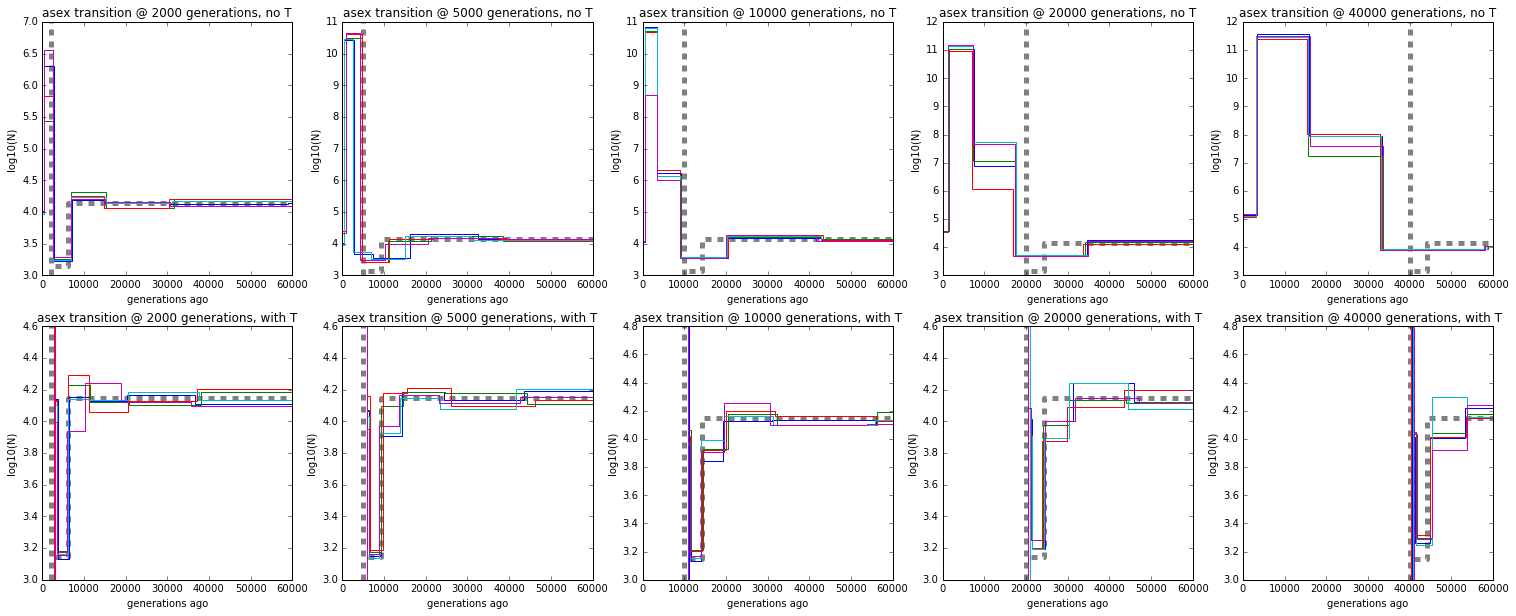

In [104]:
###### plot the standard-sim, assembly-specific simulations

fig, axes = plt.subplots(nrows=2,ncols=len(asexGens), figsize = (26,10))
for colIdx, asexGen in enumerate(asexGens):
    # first row: no T
    datp = stdAssemDat.loc[(stdAssemDat['asex'] == asexGen) & (np.isnan(stdAssemDat['divtime'])),:]
    axis = axes[0, colIdx]
    plot_psmc(axis, trueTs, trueNs, asexGen, color='gray', lw=5, ls='dashed')
    for rowIdx in xrange(datp.shape[0]):
        maxi = int(datp.ix[rowIdx,'maxi'])
        ts = datp.ix[rowIdx,'t0':('t{}'.format(maxi))]
        lambdas = datp.ix[rowIdx, 'lambda0':('lambda{}'.format(maxi))]
        divtime = datp.ix[rowIdx, 'divtime']
        if np.isnan(divtime):
            divtime = None
        plot_psmc(axis, ts, lambdas, divtime, maxt = 60000)
        axis.set_title('asex transition @ {} generations, no T'.format(asexGen))
        axis.set_xlabel('generations ago')
        axis.set_ylabel('log10(N)')
    # second row: T
    datp = stdAssemDat.loc[(stdAssemDat['asex'] == asexGen) & (~np.isnan(stdAssemDat['divtime'])),:]
    axis = axes[1, colIdx]
    plot_psmc(axis, trueTs, trueNs, asexGen, color='gray', lw=5, ls='dashed')
    for rowIdx in xrange(datp.shape[0]):
        maxi = int(datp.ix[rowIdx,'maxi'])
        ts = datp.ix[rowIdx,'t0':('t{}'.format(maxi))]
        lambdas = datp.ix[rowIdx, 'lambda0':('lambda{}'.format(maxi))]
        divtime = datp.ix[rowIdx, 'divtime']
        if np.isnan(divtime):
            divtime = None
        plot_psmc(axis, ts, lambdas, divtime, maxt = 60000)
        # add true divergence time
        axis.set_title('asex transition @ {} generations, with T'.format(asexGen))
        axis.set_xlabel('generations ago')
        axis.set_ylabel('log10(N)')

In [105]:
# now going to take the same data, use the whole genome to infer the history, make sure it's correct

datadir = "stdassemblysimdata"

stdAsexGensRescaled = asexGens/(2.0*N0)

stdMsCmdsAssemblyCheck = open('sim_ms_commands_standard_assembly_check.txt', 'w')
for asexGen in stdAsexGensRescaled:
    for rep in xrange(1, numReps+1):
        filename = "{}/standard_assembly_sim_data_t{}_rho{}_asex{}_rep{}".format(
            datadir, theta, rho, asexGen, rep)
        #msCmd = stdAssemblyMsCmd + ' | ./add_asex.py - {asexGen} > {filename}'.format(
        #    asexGen=asexGen, filename = filename)
        psmcfilename = filename.replace('_assembly_', '_assembly_check_') + '.psmc'
        ms2psmcfaCmd = './ms2psmcfa.py {msfilename}  > {psmcfilename}'.format(
            msfilename = filename, psmcfilename = psmcfilename)
        resultsfilename = '{}/results_standard_assembly_check_t{}_rho{}_asex{}_rep{}'.format(
            datadir, theta, rho, asexGen, rep)
        psmcCmd = 'psmc {} > {}'.format(psmcfilename, resultsfilename)
        resultsfilenameT = '{}/results_standard_assembly_check_t{}_rho{}_asex{}_rep{}_T'.format(datadir, theta, rho, asexGen, rep)
        psmcCmdT = 'psmc {} -T 0.5 > {}'.format(psmcfilename, resultsfilenameT)
        wholeCmd = '{} && {} && {}'.format(ms2psmcfaCmd, psmcCmd, psmcCmdT)
        stdMsCmdsAssemblyCheck.write(wholeCmd+'\n')

# control runs with constant size and no history of asex
for rep in xrange(1,numReps+1):
    filename = "{}/standard_assembly_sim_data_t{}_rho{}_no_asex_rep{}".format(datadir, theta, rho, rep)
    psmcfilename = filename.replace('_assembly_','_assembly_check_')+'.psmc'
    ms2psmcfaCmd = './ms2psmcfa.py {msfilename} > {psmcfilename}'.format(
        msfilename = filename, psmcfilename = psmcfilename)
    resultsfilename = '{}/results_standard_assembly_check_t{}_rho{}_no_asex_rep{}'.format(datadir, theta, rho, rep)
    psmcCmd = 'psmc {} > {}'.format(psmcfilename, resultsfilename)
    resultsfilenameT = '{}/results_standard_assembly_check_t{}_rho{}_no_asex_rep{}_T'.format(datadir, theta, rho, rep)
    psmcCmdT = 'psmc {} -T 0.5 > {}'.format(psmcfilename, resultsfilenameT)
    wholeCmd = '{} && {} && {}'.format(ms2psmcfaCmd, psmcCmd, psmcCmdT)
    stdMsCmdsAssemblyCheck.write(wholeCmd+'\n')
stdMsCmdsAssemblyCheck.close()

In [106]:
%%bash
#head -n 1 sim_ms_commands_standard_assembly_check.txt
#scp sim_ms_commands_standard_assembly_check.txt peter@ammodramus:/tmp/

In [107]:
# now going to take the same data, use the whole genome to infer the history, make sure it's correct

datadir = "stdassemblysimdata"

stdAssemCheckRows = {}
stdAsexGensRescaled = asexGens/(2.0*N0)

for asexGen, asexGenUnscaled in zip(stdAsexGensRescaled, asexGens):
    for rep in xrange(1, numReps+1):
        resultsfilename = '{}/results_standard_assembly_check_t{}_rho{}_asex{}_rep{}'.format(
            datadir, theta, rho, asexGen, rep)
        index = 'asex{}_rep{}'.format(asexGen, rep)
        results = read_psmc_results(resultsfilename)
        results['asex'] = asexGenUnscaled
        results['rep'] = rep
        stdAssemCheckRows[index] = results
            
        resultsfilenameT = '{}/results_standard_assembly_check_t{}_rho{}_asex{}_rep{}_T'.format(datadir, theta, rho, asexGen, rep)
        index = 'asex{}_rep{}_T'.format(asexGen, rep)
        results = read_psmc_results(resultsfilenameT)
        results['asex'] = asexGenUnscaled
        results['rep'] = rep
        stdAssemCheckRows[index] = results

# control runs with constant size and no history of asex
for rep in xrange(1,numReps+1):
    resultsfilename = '{}/results_standard_assembly_check_t{}_rho{}_no_asex_rep{}'.format(datadir, theta, rho, rep)
    resultsfilenameT = '{}/results_standard_assembly_check_t{}_rho{}_no_asex_rep{}_T'.format(datadir, theta, rho, rep)
            
    index = 'no_asex_rep{}'.format(rep)
    results = read_psmc_results(resultsfilename)
    results['asex'] = None
    results['rep'] = rep
    stdAssemCheckRows[index] = results
    
    results = read_psmc_results(resultsfilenameT)
    results['asex'] = None
    results['rep'] = rep
    stdAssemCheckRows[index] = results
            
# generate commands for std sim with assembly-specific data

stdAssemCheckDat = pd.DataFrame.from_dict(stdAssemCheckRows, orient = 'index')
maxi = int(stdAssemCheckDat['maxi'].max())
newCols = ['asex', 'rep', 'theta', 'rho', 'divtime']
newCols.extend(['lambda'+str(i) for i in xrange(0,maxi+1)])
newCols.extend(['t'+str(i) for i in xrange(0,maxi+1)])
newCols.append('maxi')
stdAssemCheckDat = stdAssemCheckDat[newCols]

# rescaling input

binSize = 100  # we binned the bp's by 100 in the input to PSMC

stdAssemCheckDat['lambda0'] = stdAssemCheckDat['theta'] / (4.0*muStd) / binSize

stdAssemCheckDat['divtime'] = 2.0*stdAssemCheckDat['lambda0'] * stdAssemCheckDat['divtime']

for i in xrange(1, maxi+1):
    colLam = 'lambda'+str(i)
    colT = 't'+str(i)
    stdAssemCheckDat[colLam] = stdAssemCheckDat['lambda0'] * stdAssemCheckDat[colLam]
    stdAssemCheckDat[colT] = 2.0*stdAssemCheckDat['lambda0'] * stdAssemCheckDat[colT]

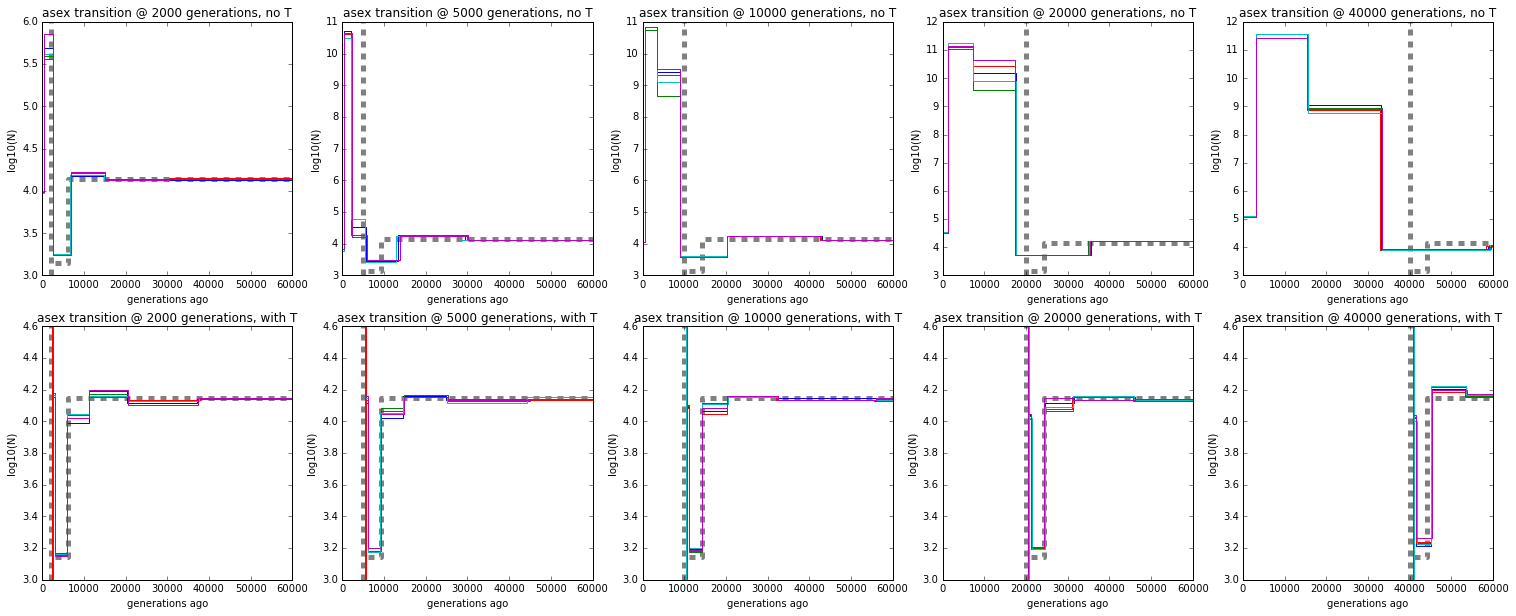

In [112]:
###### plot the standard-sim, assembly-specific simulations

fig, axes = plt.subplots(nrows=2,ncols=len(asexGens), figsize = (26,10))
for colIdx, asexGen in enumerate(asexGens):
    # first row: no T
    datp = stdAssemCheckDat.loc[(stdAssemCheckDat['asex'] == asexGen) & (np.isnan(stdAssemCheckDat['divtime'])),:]
    axis = axes[0, colIdx]
    plot_psmc(axis, trueTs, trueNs, asexGen, color='gray', lw=5, ls='dashed')
    for rowIdx in xrange(datp.shape[0]):
        maxi = int(datp.ix[rowIdx,'maxi'])
        ts = datp.ix[rowIdx,'t0':('t{}'.format(maxi))]
        lambdas = datp.ix[rowIdx, 'lambda0':('lambda{}'.format(maxi))]
        divtime = datp.ix[rowIdx, 'divtime']
        if np.isnan(divtime):
            divtime = None
        plot_psmc(axis, ts, lambdas, divtime, maxt = 60000)
        axis.set_title('asex transition @ {} generations, no T'.format(asexGen))
        axis.set_xlabel('generations ago')
        axis.set_ylabel('log10(N)')
    # second row: T
    datp = stdAssemCheckDat.loc[(stdAssemCheckDat['asex'] == asexGen) & (~np.isnan(stdAssemCheckDat['divtime'])),:]
    axis = axes[1, colIdx]
    plot_psmc(axis, trueTs, trueNs, asexGen, color='gray', lw=5, ls='dashed')
    for rowIdx in xrange(datp.shape[0]):
        maxi = int(datp.ix[rowIdx,'maxi'])
        ts = datp.ix[rowIdx,'t0':('t{}'.format(maxi))]
        lambdas = datp.ix[rowIdx, 'lambda0':('lambda{}'.format(maxi))]
        divtime = datp.ix[rowIdx, 'divtime']
        if np.isnan(divtime):
            divtime = None
        plot_psmc(axis, ts, lambdas, divtime, maxt = 60000)
        # add true divergence time
        axis.set_title('asex transition @ {} generations, with T'.format(asexGen))
        axis.set_xlabel('generations ago')
        axis.set_ylabel('log10(N)')

Fixed it! Was using the wrong $\mu$ for scaling.

# Triploid asexuals

## utility functions

In [2]:
def get_scaled_ts(result):
    i = 0
    ts = []
    while True:
        tstr = 't{}'.format(i)
        if tstr in result:
            ts.append(result[tstr])
        else:
            break
        i += 1
    return np.array(ts)

def get_lambdas(result):
    i = 0
    lambdas = []
    while True:
        tstr = 'lambda{}'.format(i)
        if tstr in result:
            lambdas.append(result[tstr])
        else:
            break
        i += 1
    return np.array(lambdas)

def get_N0(result, mu, blockLen):
    theta = result['theta']
    N0 = theta / (4.0*mu*blockLen)
    return N0

def get_Ns(result, mu, blockLen):
    N0 = get_N0(result, mu, blockLen)
    lambdas = get_lambdas(result)
    Ns = N0*lambdas
    return Ns

def get_unscaled_divtime(result, mu, blockLen):
    N0 = get_N0(result, mu, blockLen)
    divtime = result['divtime']
    if divtime is None:
        return None
    unscaledDivtime = divtime * (2.0*N0)
    return unscaledDivtime
    
def get_unscaled_ts(result, mu, blockLen):
    scTs = get_scaled_ts(result)
    N0 = get_N0(result, mu, blockLen)
    unscaledTs = 2.0*N0*scTs
    return unscaledTs

In [3]:
def read_tsmc_results(filename):
    results = {}
    results['divtime'] = None  # divtime None by default...
    fin = open(filename,'r')
    for line in fin:
        line = line.strip()
        spline = line.split('\t')
        if line[:2] == 'LR':
            results['loglike'] = float(spline[1])
            continue
        if line[:2] == 'PA':
            paramstr = spline[1]
            if paramstr == 'rho':
                results['rho'] = float(spline[2])
            if paramstr == 'theta':
                results['theta'] = float(spline[2])
            if paramstr[:3] == 'lam':
                whichLam = int(paramstr[3:])
                results['lambda{}'.format(whichLam)] = float(spline[3])
                results['t{}'.format(whichLam)] = float(spline[2])
            if paramstr[:2] == 'Td':
                results['divtime'] = float(spline[2])
    return results

In [4]:
def plot_psmc(axis, ts, lambdas, divtime = None, maxt = None, logN = True, logT = False, **plotkwargs):
    newTs = np.repeat(np.array(ts), 2)[1:]
    newLambdas = np.repeat(np.array(lambdas), 2)[:-1]
    if divtime is None:
        axis.plot(newTs, newLambdas, '-', **plotkwargs)
    else:
        baseline, = axis.plot(newTs+divtime, newLambdas, '-', **plotkwargs)
        if 'color' not in plotkwargs:
            axis.axvline(x = divtime, color = baseline.get_color(), **plotkwargs)
        else:
            axis.axvline(x = divtime, **plotkwargs)
    if maxt is not None:
        axis.set_xlim((0, maxt))
    if logT:
        axis.set_xscale('log')
    if logN:
        axis.set_yscale('log')
    return

## constant population size with asex

In [212]:
mu = 1.5e-8  # mutation rate
r = 1.0e-8  # recombination rate
N = 10000  # diploid population size in the sexual ancestor
chromLength = int(1e7)  # 10 Mbp per chromosome
#numChromosomes = 100  # simulate 100 chromosomes per replicate
numChromosomes = 10  # simulate 10 chromosomes per replicate

# scaled parameters for entire chromosomes
rho = 4*N*r*chromLength
theta = 4*N*mu*chromLength

# the different transition times to test
asexGens = np.array([2000, 5000, 10000, 20000, 40000])
asexGensRescaled = asexGens / (2.0*N)  # rescaled by 2*N

In [213]:
msCmd = "mspms 3 {numChroms} -r {rho} {chromLen} -t {theta} -p 10".format(
    numChroms = numChromosomes,
    chromLen = chromLength,
    rho = rho,
    theta = theta)

In [214]:
msCmd

'mspms 3 10 -r 4000.0 10000000 -t 6000.0 -p 10'

In [215]:
float(rho)/chromLength*100

0.04

In [274]:
# with 0.5 asex gens

divtimes = [0.25, 0.5, 1.0]

msCmd = "mspms 3 {numChroms} -r {rho} {chromLen} -t {theta} -p 10".format(
    numChroms = numChromosomes,
    chromLen = chromLength,
    rho = rho,
    theta = theta)

addAsexCmds = ["./add_asex.py --triploid - {}".format(divtime) for divtime in divtimes]

filenames = ['triploid_const_N_asex_{asex}.txt'.format(asex = divtime) for divtime in divtimes]
resultsfilenames = ['triploid_const_N_asex_{asex}.results'.format(asex = divtime) for divtime in divtimes]

In [275]:
ms2tsmcfaCmd = "./ms2psmcfa.py"

In [276]:
fullCmds = ["{} | {} | {} > {}".format(msCmd, asexCmd, ms2tsmcfaCmd, filename) for asexCmd, filename in zip(addAsexCmds, filenames)]

In [277]:
fullCmds

['mspms 3 10 -r 4000.0 10000000 -t 6000.0 -p 10 | ./add_asex.py --triploid - 0.25 | ./ms2psmcfa.py > triploid_const_N_asex_0.25.txt',
 'mspms 3 10 -r 4000.0 10000000 -t 6000.0 -p 10 | ./add_asex.py --triploid - 0.5 | ./ms2psmcfa.py > triploid_const_N_asex_0.5.txt',
 'mspms 3 10 -r 4000.0 10000000 -t 6000.0 -p 10 | ./add_asex.py --triploid - 1.0 | ./ms2psmcfa.py > triploid_const_N_asex_1.0.txt']

In [278]:
#with open('tsmc/triploid_const_asex_data_generation_cmds', 'w') as generationFout:
#    for fullCmd in fullCmds:
#        generationFout.write(fullCmd + '\n')

In [279]:
pattern = "4*4"
iterations = 50

In [280]:
analysisCmds = ['stdbuf -o0 -e0 -i0 ./tsmc -p {pattern}  -i {iterations} {filename} > {resultsfilename}'.format(
    pattern = pattern,
    iterations = iterations,
    filename = filename,
    resultsfilename = resultsfilename) for filename, resultsfilename in zip(filenames, resultsfilenames)]

analysisCmds

with open('tsmc/triploid_const_asex_analysis_cmds', 'w') as analysisFout:
    for analysisCmd in analysisCmds:
        analysisFout.write(analysisCmd + '\n')

In [281]:
mu = 1.5e-8  # mutation rate
r = 1.0e-8  # recombination rate
N = 10000  # diploid population size in the sexual ancestor
chromLength = int(1e7)  # 10 Mbp per chromosome
#numChromosomes = 100  # simulate 100 chromosomes per replicate
numChromosomes = 10  # simulate 10 chromosomes per replicate

trueTs = np.array([0,10000000])
trueNs = np.array([10000,10000])

In [282]:
results = {}
for divtime, resultsfilename in zip(divtimes, resultsfilenames):
    results[divtime] = read_tsmc_results(resultsfilename)
    results[divtime]['truedivtime'] = divtime

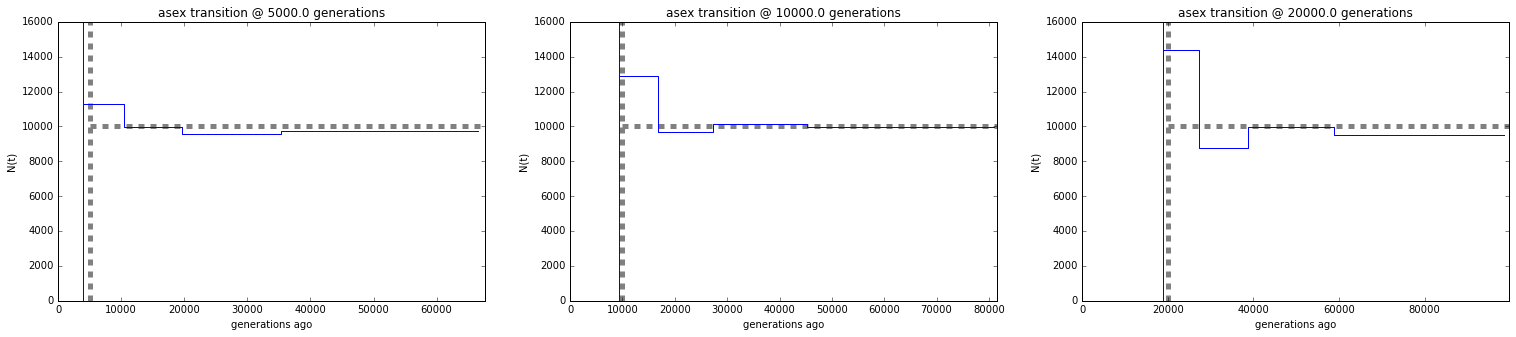

In [291]:
fig, axes = plt.subplots(nrows=1,ncols=len(divtimes), figsize = (26,5))
for colIdx, divtime in enumerate(divtimes):
    axis = axes[colIdx]
    result = results[divtime]
    ts = get_unscaled_ts(result, mu, 100)
    Ns = get_Ns(result, mu, 100)
    divtime *= 2*N
    plot_psmc(axis, trueTs, trueNs, divtime, color='gray', lw=5, ls='dashed', logN = False)
    estimatedDivtime = get_unscaled_divtime(result, mu, 100)
    axis.set_title('asex transition @ {} generations'.format(divtime))
    axis.set_xlabel('generations ago')
    axis.set_ylabel('N(t)')
    axis.set_ylim((0,16000))
    axis.set_xlim((0,max(ts)+divtime))
    plot_psmc(axis, ts, Ns, divtime = estimatedDivtime, logN = False)
plt.savefig('const_N_simulations.png', dpi=300)

## PSMC 'standard' demographic history with triploid inference

The ms command to generate their "standard simulation," from the paper:

    ms 2 100 -t 81960 -r 13560 30000000 -eN 0.01 0.05 -eN 0.0375 0.5 -eN 1.25 1

This sets $N_0 = 28000$, $\theta = 4N_0\mu = 81960$,
thus $\mu = 2.44 \times 10^{-8}$, $\rho = 4N_0r = 13560$, thus
$r = 4.04 \times 10^{-9}$.

Changes in population size:

 - at 1120 generations, $N_0 \to N_1 = 1400$
 - at 4200 generations, $N_1 \to N_2 = 14000$
 - at 140000 generations, $N_2 \to N_3 = 28000$

To better reflect our genome (and decrease computation time), I will do simulations of 120Mb instead of 3000Mb:

	ms 3 40 -t 8196 -r 1356 3000000 -eN 0.01 0.05 -eN 0.0375 0.5 -eN 1.25 1

\begin{align}
\theta &= 4N_0\mu L \\
       &= 4\cdot 28000 \cdot 2.44\cdot 10^{-8} \cdot 3000000\\
       &\approx 8196
\end{align}

In [248]:
trueTs = np.array([0,1120,4200,140000,200000])
trueNs = np.array([28000,1400,14000,28000,28000])
mu = 2.44e-8
r = 4.04e-9
trueN0 = 28000

In [250]:
divtimes = [0.25, 0.5, 1.0]

msStdCmdTriploid = 'mspms 3 40 -t 8196 -r 1356 3000000 -eN 0.01 0.05 -eN 0.0375 0.5 -eN 1.25 1 -p 12'

addAsexCmds = ["./add_asex.py --triploid - {}".format(divtime) for divtime in divtimes]
ms2tsmcfaCmd = "./ms2psmcfa.py"

filenames = ['triploid_std_demo_asex_{asex}.txt'.format(asex = divtime) for divtime in divtimes]
resultsfilenames = ['triploid_std_demo_asex_{asex}.results'.format(asex = divtime) for divtime in divtimes]

In [251]:
fullCmds = ["{} | {} | {} > {}".format(msStdCmdTriploid, asexCmd, ms2tsmcfaCmd, filename) for asexCmd, filename in zip(addAsexCmds, filenames)]

In [252]:
with open('triploid_std_generation_cmds', 'w') as fout:
    for fullCmd in fullCmds:
        fout.write(fullCmd + '\n')

In [253]:
pattern = '5*4'

In [254]:
analysisCmds = ['stdbuf -o0 -e0 -i0 tsmc/tsmc -p {pattern} -i {iterations} {filename} > {resultsfilename}'.format(
    pattern = pattern,
    iterations = iterations,
    filename = filename,
    resultsfilename = resultsfilename) for filename, resultsfilename in zip(filenames, resultsfilenames)]

In [255]:
with open('triploid_std_analysis_cmds', 'w') as fout:
    for analysisCmd in analysisCmds:
        fout.write(analysisCmd + '\n')

In [256]:
%%bash
#scp triploid_std_*_cmds peter@ammodramus:~/bio/snail/

In [257]:
%%bash
#scp peter@ammodramus:~/bio/snail/triploid_std_demo_asex_{0.25,0.5,1.0}.results .

In [258]:
results = {}
for divtime, resultsfilename in zip(divtimes, resultsfilenames):
    results[divtime] = read_tsmc_results(resultsfilename)
    results[divtime]['truedivtime'] = divtime

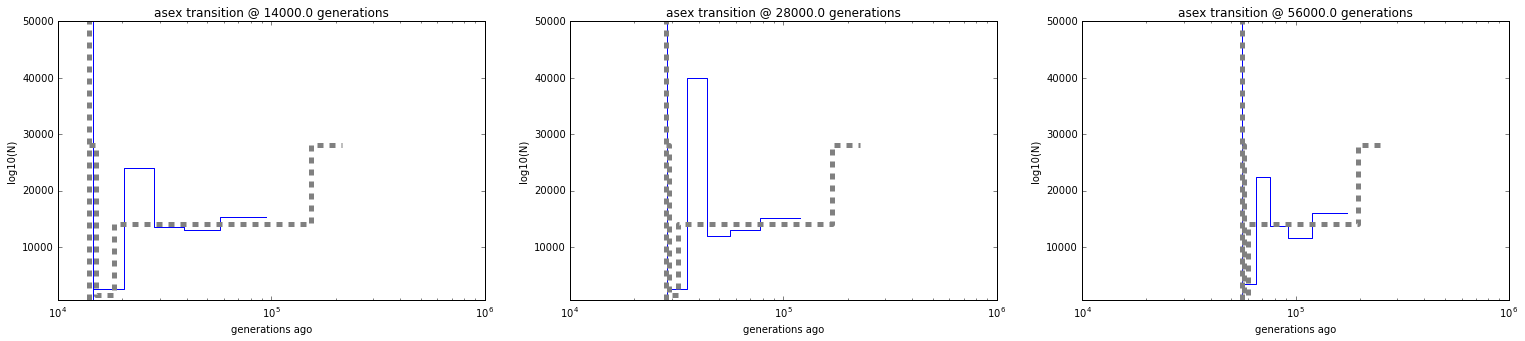

In [260]:
# all lambdas are free, tmax is not
fig, axes = plt.subplots(nrows=1,ncols=len(divtimes), figsize = (26,5))
for colIdx, divtime in enumerate(divtimes):
    axis = axes[colIdx]
    result = results[divtime]
    ts = get_unscaled_ts(result, mu, 100)
    Ns = get_Ns(result, mu, 100)
    divtime *= 2*trueN0
    estimatedDivtime = get_unscaled_divtime(result, mu, 100)
    axis.set_title('asex transition @ {} generations'.format(divtime))
    axis.set_xlabel('generations ago')
    axis.set_ylabel('log10(N)')
    axis.set_ylim((5e2,5e4))
    plot_psmc(axis, ts, Ns, divtime = estimatedDivtime, logN = False, logT = True)
    plot_psmc(axis, trueTs, trueNs, divtime = divtime, color='gray', lw=5, ls='dashed', logN = False, logT = True)

## free time

In [261]:
resultsfilenamesFreetime = ['triploid_std_demo_asex_0.25_freetime.results',
 'triploid_std_demo_asex_0.5_freetime.results',
 'triploid_std_demo_asex_1.0_freetime.results']

In [262]:
results = {}
for divtime, resultsfilename in zip(divtimes, resultsfilenamesFreetime):
    results[divtime] = read_tsmc_results(resultsfilename)
    results[divtime]['truedivtime'] = divtime

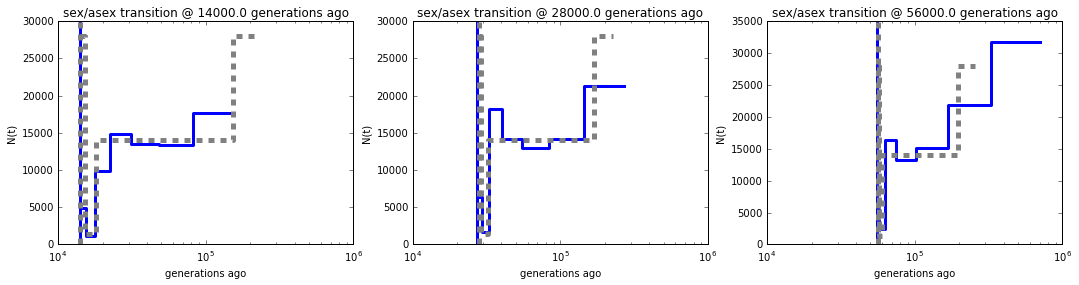

In [267]:
# all lambdas are free, tmax is not
fig, axes = plt.subplots(nrows=1,ncols=len(divtimes), figsize = (18,4))
for colIdx, divtime in enumerate(divtimes):
    axis = axes[colIdx]
    result = results[divtime]
    ts = get_unscaled_ts(result, mu, 100)
    Ns = get_Ns(result, mu, 100)
    divtime *= 2*trueN0
    estimatedDivtime = get_unscaled_divtime(result, mu, 100)
    axis.set_title('sex/asex transition @ {} generations ago'.format(divtime))
    axis.set_xlabel('generations ago')
    axis.set_ylabel('N(t)')
    #axis.set_ylim((1e3,1e5))
    plot_psmc(axis, ts, Ns, divtime = estimatedDivtime, logT = True, logN = False, lw=3)
    plot_psmc(axis, trueTs, trueNs, divtime = divtime, color='gray', lw=5, ls='dashed', logT = True, logN = False)

Free time is even better.

## more reps of PSMC std simulation, longer sequence

This time also do no-asex simulations and do 10 reps of each.

## summary
The ms command to generate their "standard simulation," from the paper:

    ms 2 100 -t 81960 -r 13560 30000000 -eN 0.01 0.05 -eN 0.0375 0.5 -eN 1.25 1

This sets $N_0 = 28000$, $\theta = 4N_0\mu = 81960$,
thus $\mu = 2.44 \times 10^{-8}$, $\rho = 4N_0r = 13560$, thus
$r = 4.04 \times 10^{-9}$.

Changes in population size:

 - at 1120 generations, $N_0 \to N_1 = 1400$
 - at 4200 generations, $N_1 \to N_2 = 14000$
 - at 140000 generations, $N_2 \to N_3 = 28000$

To better reflect our genome (and decrease computation time), I will do simulations of 120Mb instead of 3000Mb:

	ms 3 40 -t 8196 -r 1356 3000000 -eN 0.01 0.05 -eN 0.0375 0.5 -eN 1.25 1

In [52]:
trueTs = np.array([0,1120,4200,140000,200000])
trueNs = np.array([28000,1400,14000,28000,28000])
mu = 2.44e-8
r = 4.04e-9
trueN0 = 28000

In [61]:
numReps = 10
divtimes = [0.0, 0.25, 0.5, 1.0]

msStdCmdTriploid = 'mspms 3 40 -t 8196 -r 1356 3000000 -eN 0.01 0.05 -eN 0.0375 0.5 -eN 1.25 1 -p 12'

addAsexCmds = ["./add_asex.py --triploid - {}".format(divtime) for divtime in divtimes]
ms2tsmcfaCmd = "./ms2psmcfa.py"
iterations = 20

mu = 2.44e-8
r = 4.04e-9
trueN0 = 28000

In [62]:
filenames = []
resultsfilenames = []
fullCmds = []
for addAsexCmd, divtime in zip(addAsexCmds, divtimes):
    for rep in range(1,numReps+1):
        filename = 'triploid_std_demo_asex{asex}_rep{rep}.txt'.format(asex = divtime, rep = rep)
        resultsfilename = 'triploid_std_demo_asex{asex}_rep{rep}.results'.format(asex = divtime, rep = rep)
        filenames.append(filename)
        resultsfilenames.append(resultsfilename)
        fullCmds.append("{} | {} | {} > {}".format(msStdCmdTriploid, addAsexCmd, ms2tsmcfaCmd, filename) )

In [63]:
#with open('triploid_std_generation_cmds_more_reps', 'w') as fout:
#    for fullCmd in fullCmds:
#        fout.write(fullCmd + '\n')

In [64]:
analysisCmds = ['stdbuf -o0 -e0 -i0 tsmc/tsmc -i {iterations} {datadir}/{filename} > {datadir}/{resultsfilename}'.format(
    datadir = "triploid_std_demo_data",
    iterations = iterations,
    filename = filename,
    resultsfilename = resultsfilename) for filename, resultsfilename in zip(filenames, resultsfilenames)]

In [65]:
#with open('triploid_std_analysis_cmds_more_reps', 'w') as fout:
#    for analysisCmd in analysisCmds:
#        fout.write(analysisCmd + '\n')

In [66]:
%%bash
#scp triploid_std_*_cmds_more_reps peter@ammodramus:~/bio/snail/

In [67]:
def make_odyssey_runfile_std_sim(asex, rep, maxHours = 96, queue = "general", mem = 8000,
                                iterations = 20):
    header = '''#!/bin/bash

#SBATCH -n 1
#SBATCH -N 1
#SBATCH -t 0-{maxHours}:00
#SBATCH -p {queue}
#SBATCH --mem {mem}
#SBATCH -o tsmc_std_sim_asex{asex}_rep{rep}.out
#SBATCH -e tsmc_std_sim_asex{asex}_rep{rep}.err
'''.format(
        maxHours = maxHours, queue = queue, mem = mem, asex = asex, rep = rep)
    filepath = 'triploid_std_demo_data/triploid_std_demo_asex{asex}_rep{rep}.txt'.format(asex = asex, rep = rep)
    resultsfilepath = 'triploid_std_demo_data/triploid_std_demo_asex{asex}_rep{rep}.results'.format(asex = asex, rep = rep)
    cmd = 'stdbuf -o0 -e0 -i0 tsmc/tsmc -i {iterations} {filepath} > {resultsfilepath}'.format(
        iterations = iterations,
        filepath = filepath,
        resultsfilepath = resultsfilepath)
    return header + '\n' + cmd

In [68]:
#for asex in divtimes:
#    for rep in range(1, numReps+1):
#        runcmdfilename = 'run_std_sim_asex{}_rep{}.sh'.format(asex, rep)
#        with open(runcmdfilename, 'w') as fout:
#            fout.write(make_odyssey_runfile_std_sim(asex,rep)+'\n')

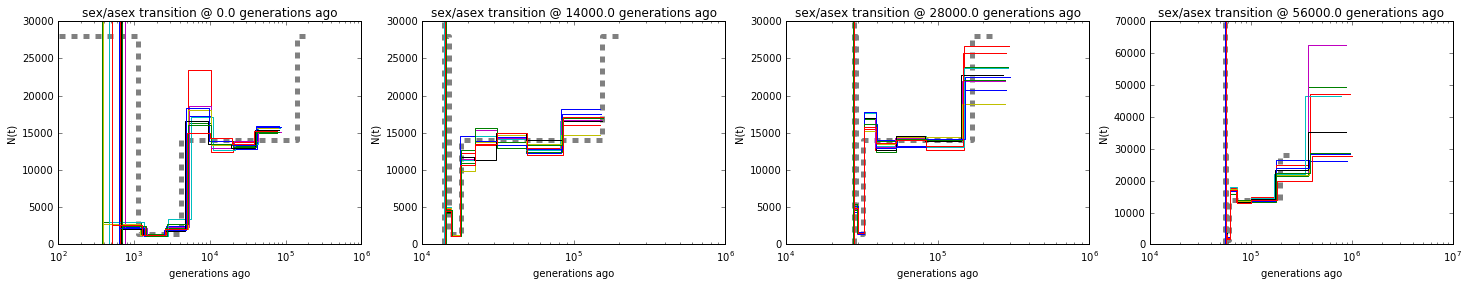

In [72]:
fig, axes = plt.subplots(nrows=1,ncols=len(divtimes), figsize = (25,4))
for asex, axis in zip(divtimes, axes):
    truedivtime = 2*trueN0*asex
    axis.set_title('sex/asex transition @ {} generations ago'.format(truedivtime))
    axis.set_xlabel('generations ago')
    axis.set_ylabel('N(t)')
    plot_psmc(axis, trueTs, trueNs, divtime = truedivtime, color='gray', lw=5, ls='dashed', logT = True, logN = False)
    for rep in range(1, numReps+1):
        resultsfilepath = "{resultsdir}/triploid_std_demo_asex{asex}_rep{rep}.results".format(
            resultsdir =  "triploid_std_demo_data",
            asex = asex,
            rep = rep)
        result = read_tsmc_results(resultsfilepath)
        result['truedivtime'] = divtime
        ts = get_unscaled_ts(result, mu, 100)
        Ns = get_Ns(result, mu, 100)
        estimatedDivtime = get_unscaled_divtime(result, mu, 100)
        plot_psmc(axis, ts, Ns, divtime = estimatedDivtime, logT = True, logN = False, lw=1)
        

## Exponential growth

Want to do the same, but with exponential growth. Below is the simulation diploid simulation I did of recent exponential growth:



In [76]:
N0 = 1000000
N1 = 5000
Tgrowth = 100

rescaledN1 = N1 / (4.0*N0)
rescaledTgrowth = Tgrowth / (4.0*N0)
growthRate = np.log(float(N0)/N1) / rescaledTgrowth

mu = 1.5e-8
r = 1.0e-8  # recombination rate
chromLength = int(1e7)  # 10 Mbp per chromosome
numChromosomes = 12  # simulate 120 Mb total

# scaled parameters for entire chromosomes
rho = 4*N0*r*chromLength
theta = 4*N0*mu*chromLength

numReps = 5

# the different transition times to test
asexGens = np.array([2000, 5000, 10000, 20000, 40000])
asexGensRescaled = asexGens / (2.0*N0)  # rescaled by 2*N

trueTs = [0, 100,100000]
trueNs = [1000000, 5000,5000]

In [77]:
msCmd = 'mspms 3 {numChroms} -t {theta} -r {rho} {chromLen} -eG 0 {growthRate} -eN {rescaledTgrowth} {rescaledN1} -p 12'.format(
    numChroms = numChromosomes, theta = theta, rho = rho, chromLen = chromLength, growthRate = growthRate,
    rescaledTgrowth = rescaledTgrowth, rescaledN1 = rescaledN1)
addAsexCmdTemplate = './add_asex.py --triploid - {}'
ms2psmcfaCmd = './ms2psmcfa.py'

In [78]:
asexGens = [0.0, 0.25, 0.5, 1.0]
numReps = 10

In [79]:
exponentialDir = 'triploid_exp_sim_data'
filenameTemplate = '{filedir}/triploid_exp_sim_asex{asex}_rep{rep}.txt'
resultsfilenameTemplate = '{filedir}/triploid_exp_sim_asex{asex}_rep{rep}.results'
expGenerationCmds = []
for asex in asexGens:
    addAsexCmd = addAsexCmdTemplate.format(asex)
    for rep in range(1,numReps+1):
        filename = filenameTemplate.format(filedir = exponentialDir, asex = asex, rep = rep) 
        resultsfilename = resultsfilenameTemplate.format(filedir = exponentialDir, asex = asex, rep = rep) 
        generationCmd = '{} | {} | {} > {}'.format(msCmd, addAsexCmd, ms2psmcfaCmd, filename)
        expGenerationCmds.append(generationCmd)

In [80]:
#with open('triploid_exp_generation_cmds','w') as fout:
#    for cmd in expGenerationCmds:
#        fout.write(cmd + '\n')

In [81]:
%%bash
#scp triploid_exp_generation_cmds peter@ammodramus:~/bio/snail/
# simulated on ammodramus, scp'ed to odyssey

In [82]:
def make_odyssey_runfile_exp_sim(asex, rep, maxHours = 96, queue = "general", mem = 8000,
                                iterations = 20):
    header = '''#!/bin/bash

#SBATCH -n 1
#SBATCH -N 1
#SBATCH -t 0-{maxHours}:00
#SBATCH -p {queue}
#SBATCH --mem {mem}
#SBATCH -o tsmc_exp_sim_asex{asex}_rep{rep}.out
#SBATCH -e tsmc_exp_sim_asex{asex}_rep{rep}.err
'''.format(
        maxHours = maxHours, queue = queue, mem = mem, asex = asex, rep = rep)
    filepath = 'triploid_exp_sim_data/triploid_exp_sim_asex{asex}_rep{rep}.txt'.format(asex = asex, rep = rep)
    resultsfilepath = 'triploid_exp_sim_data/triploid_exp_sim_asex{asex}_rep{rep}.results'.format(asex = asex, rep = rep)
    cmd = 'stdbuf -o0 -e0 -i0 tsmc/tsmc -i {iterations} {filepath} > {resultsfilepath}'.format(
        iterations = iterations,
        filepath = filepath,
        resultsfilepath = resultsfilepath)
    return header + '\n' + cmd

In [83]:
#for asex in divtimes:
#    for rep in range(1, numReps+1):
#        runcmdfilename = 'run_exp_sim_asex{}_rep{}.sh'.format(asex, rep)
#        with open(runcmdfilename, 'w') as fout:
#            fout.write(make_odyssey_runfile_exp_sim(asex,rep)+'\n')

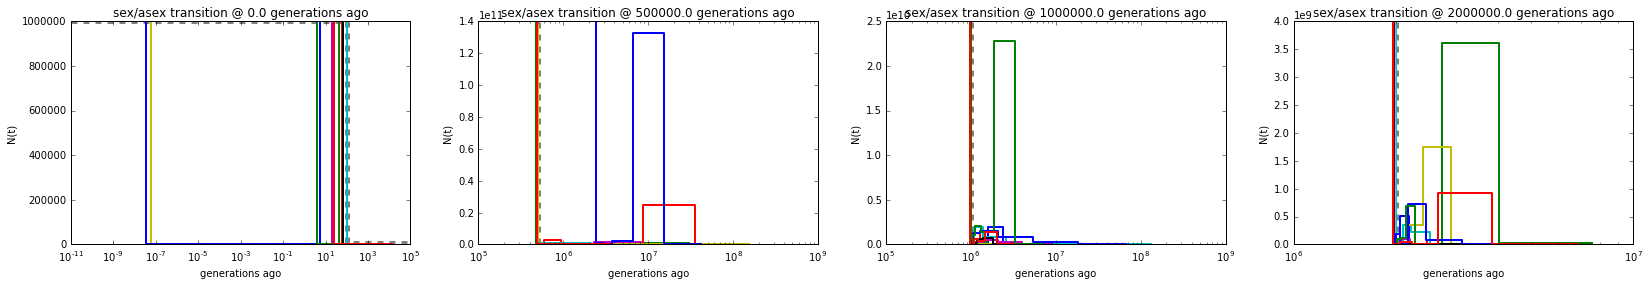

In [87]:
fig, axes = plt.subplots(nrows=1,ncols=len(divtimes), figsize = (28,4))
for asex, axis in zip(divtimes, axes):
    truedivtime = 2*N0*asex
    axis.set_title('sex/asex transition @ {} generations ago'.format(truedivtime))
    axis.set_xlabel('generations ago')
    axis.set_ylabel('N(t)')
    plot_psmc(axis, trueTs, trueNs, divtime = truedivtime, color='gray', lw=5, ls='dashed', logT = True, logN = False)
    for rep in range(1, numReps+1):
        resultsfilepath = "{resultsdir}/triploid_exp_sim_asex{asex}_rep{rep}.results".format(
            resultsdir =  "triploid_exp_sim_data",
            asex = asex,
            rep = rep)
        result = read_tsmc_results(resultsfilepath)
        result['truedivtime'] = divtime
        ts = get_unscaled_ts(result, mu, 100)
        Ns = get_Ns(result, mu, 100)
        estimatedDivtime = get_unscaled_divtime(result, mu, 100)
        plot_psmc(axis, ts, Ns, divtime = estimatedDivtime, logT = True, logN = False, lw=2)
        

The above simulations demonstrate that when the sex-to-asex transition time gets very large, the transition time is inferred well, but the demographic history of the sexual ancestor is lost. This makes sense: lots of Meselson-effect mutations should erode the signature of the sexual ancestor's population history.

## Simulations of different recent transitions

In [63]:
numGens = [0, 100, 200, 400, 800, 1600]  # number of *generations* of asex
numReps = 10
mu = 1.5e-8  # mutation rate
r = 1.0e-8  # recombination rate
N = 10000  # diploid population size in the sexual ancestor
chromLen = int(1e7)  # 10 Mbp per chromosome
numChromosomes = 10  # simulate 10 chromosomes per replicate

trueTs = np.array([0,400000])
trueNs = np.array([N, N])

totalTheta = 4.0*N*mu*chromLen
totalRho = 4.0*N*r*chromLen

In [64]:
# generating the data with mspms

msCmd = "mspms 3 {numChroms} -t {theta} -r {rho} {chromLen} -p 12".format(
    numChroms = numChromosomes,
    theta = totalTheta,
    rho = totalRho,
    chromLen = chromLen
    )
addAsexCmdTemplate = "./add_asex.py --triploid - {divtime}"
ms2tsmcfaCmd = "./ms2psmcfa.py"

# mkdir -p this dir...
resultsDir = "triploid_recent_const_N_data"

_ = '''
with open('triploid_recent_const_N_generation_cmds', 'w') as fout:
    for numGen in numGens:
        rescaledNumGen = float(numGen) / (2.0*N)
        addAsexCmd = addAsexCmdTemplate.format(divtime = rescaledNumGen)
        for rep in range(1, numReps+1):
            datafilename = "triploid_recent_const_N_asex{}_rep{}.txt".format(
                rescaledNumGen, rep)
            runCmd = "{} | {} | {} > {}/{}".format(
                msCmd, addAsexCmd, ms2tsmcfaCmd, resultsDir, datafilename)
            fout.write(runCmd + '\n')
'''

In [65]:
%%bash
#scp triploid_recent_const_N_generation_cmds peter@ammodramus:~/bio/snail/

In [66]:
def make_odyssey_recent_sim(asex, rep, maxHours = 96, queue = "general", mem = 8000,
                                iterations = 20):
    header = '''#!/bin/bash

#SBATCH -n 1
#SBATCH -N 1
#SBATCH -t 0-{maxHours}:00
#SBATCH -p {queue}
#SBATCH --mem {mem}
#SBATCH -o tsmc_recent_sim_asex{asex}_rep{rep}.out
#SBATCH -e tsmc_recent_sim_asex{asex}_rep{rep}.err
'''.format(
        maxHours = maxHours, queue = queue, mem = mem, asex = asex, rep = rep)
    filepath = 'triploid_recent_const_N_data/triploid_recent_const_N_asex{asex}_rep{rep}.txt'.format(
        asex = asex, rep = rep)
    resultsfilepath = 'triploid_recent_const_N_data/triploid_recent_const_N_asex{asex}_rep{rep}.results'.format(
        asex = asex, rep = rep)
    cmd = 'stdbuf -o0 -e0 -i0 tsmc/tsmc -i {iterations} {filepath} > {resultsfilepath}'.format(
        iterations = iterations,
        filepath = filepath,
        resultsfilepath = resultsfilepath)
    return header + '\n' + cmd

In [67]:
#for numGen in numGens:
#    for rep in range(1, numReps+1):
#        scaledAsex = float(numGen) / (2.0*N)
#        runCmdFilename = "run_recent_const_N_asex{asex}_rep{rep}.sh".format(
#            asex = scaledAsex, rep = rep)
#        with open(runCmdFilename, 'w') as fout:
#            fout.write(make_odyssey_recent_sim(scaledAsex, rep)+'\n')

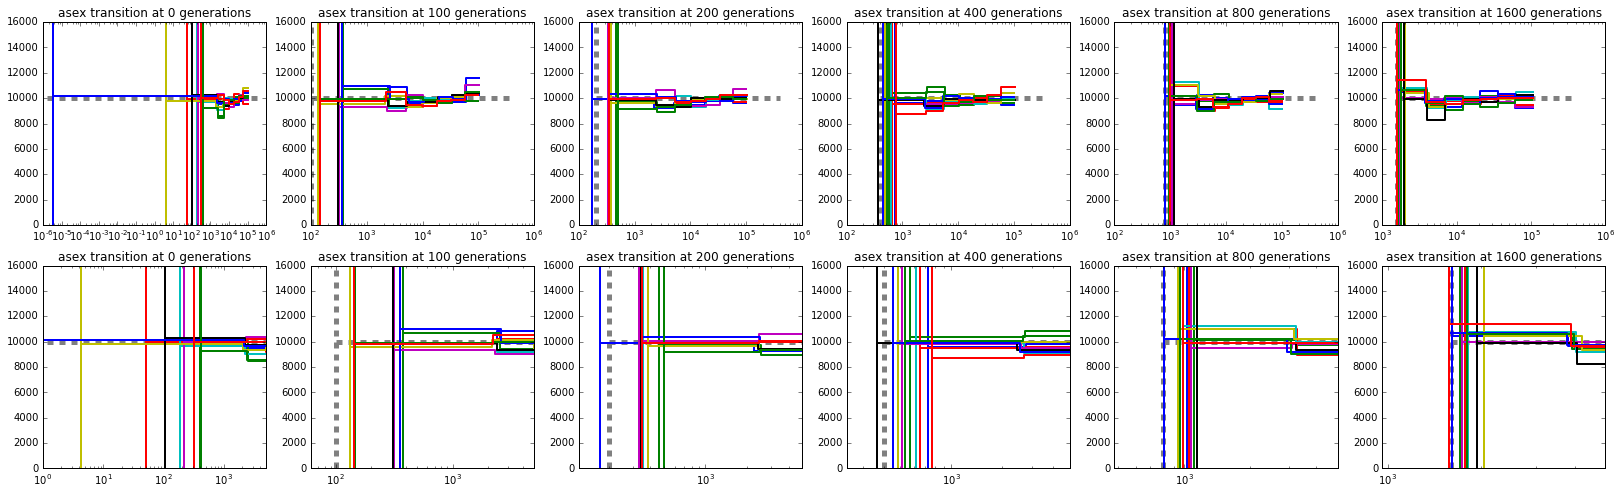

In [68]:
# read in the results
resultsDir = 'triploid_recent_const_N_data'
fig, axes = plt.subplots(nrows=2,ncols=len(numGens), figsize = (28,8))
for asex, axis in zip(numGens, axes[0]):
    rescaledAsex = float(asex) / (2.0 * N)
    plot_psmc(axis, trueTs, trueNs, divtime = asex, logT = True, logN = False, lw = 5, ls = 'dashed', color = 'gray')
    axis.set_ylim((0,16000))
    axis.set_title('asex transition at {} generations'.format(asex))
    for rep in range(1, numReps+1):
        filename = '{rdir}/triploid_recent_const_N_asex{asex}_rep{rep}.results'.format(
            rdir = resultsDir,
            asex = rescaledAsex,
            rep = rep)
        result = read_tsmc_results(filename)
        result['truedivtime'] = rescaledAsex
        ts = get_unscaled_ts(result, mu, 100)
        Ns = get_Ns(result, mu, 100)
        estimatedDivtime = get_unscaled_divtime(result, mu, 100)
        plot_psmc(axis, ts, Ns, divtime = estimatedDivtime, logT = True, logN = False, lw=2)
for asex, axis in zip(numGens, axes[1]):
    rescaledAsex = float(asex) / (2.0 * N)
    plot_psmc(axis, trueTs, trueNs, divtime = asex, logT = True, logN = False, lw = 5, ls = 'dashed', color = 'gray')
    axis.set_ylim((0,16000))
    axis.set_xlim((0.6*asex+1,5000))
    if asex > 0.0:
        axis.set_xticks(np.arange(0.9*asex, 5000, step = (5000-0.9*asex)/10))
    axis.set_title('asex transition at {} generations'.format(asex))
    for rep in range(1, numReps+1):
        filename = '{rdir}/triploid_recent_const_N_asex{asex}_rep{rep}.results'.format(
            rdir = resultsDir,
            asex = rescaledAsex,
            rep = rep)
        result = read_tsmc_results(filename)
        result['truedivtime'] = rescaledAsex
        ts = get_unscaled_ts(result, mu, 100)
        Ns = get_Ns(result, mu, 100)
        estimatedDivtime = get_unscaled_divtime(result, mu, 100)
        plot_psmc(axis, ts, Ns, divtime = estimatedDivtime, logT = True, logN = False, lw=2)

## Fig. 2 PSMC simulation with recent transitions

### summary
The ms command to generate their "standard simulation," from the paper:

    ms 2 100 -t 81960 -r 13560 30000000 -eN 0.01 0.05 -eN 0.0375 0.5 -eN 1.25 1

This sets $N_0 = 28000$, $\theta = 4N_0\mu = 81960$,
thus $\mu = 2.44 \times 10^{-8}$, $\rho = 4N_0r = 13560$, thus
$r = 4.04 \times 10^{-9}$.

Changes in population size:

 - at 1120 generations, $N_0 \to N_1 = 1400$
 - at 4200 generations, $N_1 \to N_2 = 14000$
 - at 140000 generations, $N_2 \to N_3 = 28000$

To better reflect our genome (and decrease computation time), I will do simulations of 120Mb instead of 3000Mb:

	ms 3 40 -t 8196 -r 1356 3000000 -eN 0.01 0.05 -eN 0.0375 0.5 -eN 1.25 1

In [86]:
numReps = 10

trueTs = np.array([0,1120,4200,140000,200000])
trueNs = np.array([28000,1400,14000,28000,28000])

mu = 2.44e-8
r = 4.04e-9

trueN0 = trueNs[0]

numGens = [0, 100, 200, 400, 800, 1600]
numReps = 10

totalTheta = 8196
totalRho = 1356

numChroms = 40
chromLen = 3000000

mu = float(totalTheta)/(chromLen * 4.0 * trueN0)
r = float(totalRho) / (chromLen * 4.0 * trueN0)

In [87]:
msCmd = "mspms 3 {numChroms} -t {totalTheta} -r {totalRho} {chromLen} -eN 0.01 0.05 -eN 0.0375 0.5 -eN 1.25 1 -p 12".format(
    numChroms = numChroms,
    totalTheta = totalTheta,
    totalRho = totalRho,
    chromLen = chromLen)
addAsexCmdTemplate = './add_asex.py --triploid - {asex}'
ms2tsmcfaCmd = './ms2psmcfa.py'

datadir = 'triploid_std_recent_data'

with open('run_recent_std_cmds', 'w') as fout:
    for numGensAsex in numGens:
        scaledAsex = float(numGensAsex) / (2.0 * trueN0)
        addAsexCmd = addAsexCmdTemplate.format(asex = scaledAsex)
        for rep in range(1, numReps+1):
            datafilename = '{datadir}/triploid_std_recent_asex{asex}_rep{rep}.txt'.format(
                datadir = datadir, asex = scaledAsex, rep = rep)
            wholeCmd = '{} | {} | {} > {}'.format(
                msCmd, addAsexCmd, ms2tsmcfaCmd, datafilename)
            fout.write(wholeCmd + '\n')

In [88]:
%%bash
#scp run_recent_std_cmds peter@ammodramus:~/bio/snail/

In [89]:
def make_odyssey_recent_std_sim(asex, rep, maxHours = 96, queue = "general", mem = 8000,
                                iterations = 20):
    header = '''#!/bin/bash

#SBATCH -n 1
#SBATCH -N 1
#SBATCH -t 0-{maxHours}:00
#SBATCH -p {queue}
#SBATCH --mem {mem}
#SBATCH -o tsmc_recent_std_asex{asex}_rep{rep}.out
#SBATCH -e tsmc_recent_std_asex{asex}_rep{rep}.err
'''.format(
        maxHours = maxHours, queue = queue, mem = mem, asex = asex, rep = rep)
    filepath = 'triploid_std_recent_data/triploid_std_recent_asex{asex}_rep{rep}.txt'.format(
        asex = asex, rep = rep)
    resultsfilepath = 'triploid_std_recent_data/triploid_std_recent_asex{asex}_rep{rep}.results'.format(
        asex = asex, rep = rep)
    cmd = 'stdbuf -o0 -e0 -i0 tsmc/tsmc -i {iterations} {filepath} > {resultsfilepath}'.format(
        iterations = iterations,
        filepath = filepath,
        resultsfilepath = resultsfilepath)
    return header + '\n' + cmd

In [90]:
#for numGen in numGens:
#    scaledNumGens = numGen / (2.0*trueN0)
#    for rep in range(1,numReps+1):
#        shFilename = 'run_std_recent_asex{asex}_rep{rep}.sh'.format(
#            asex = scaledNumGens, rep = rep)
#        with open(shFilename, 'w') as fout:
#            fout.write(make_odyssey_recent_std_sim(scaledNumGens, rep) + '\n')

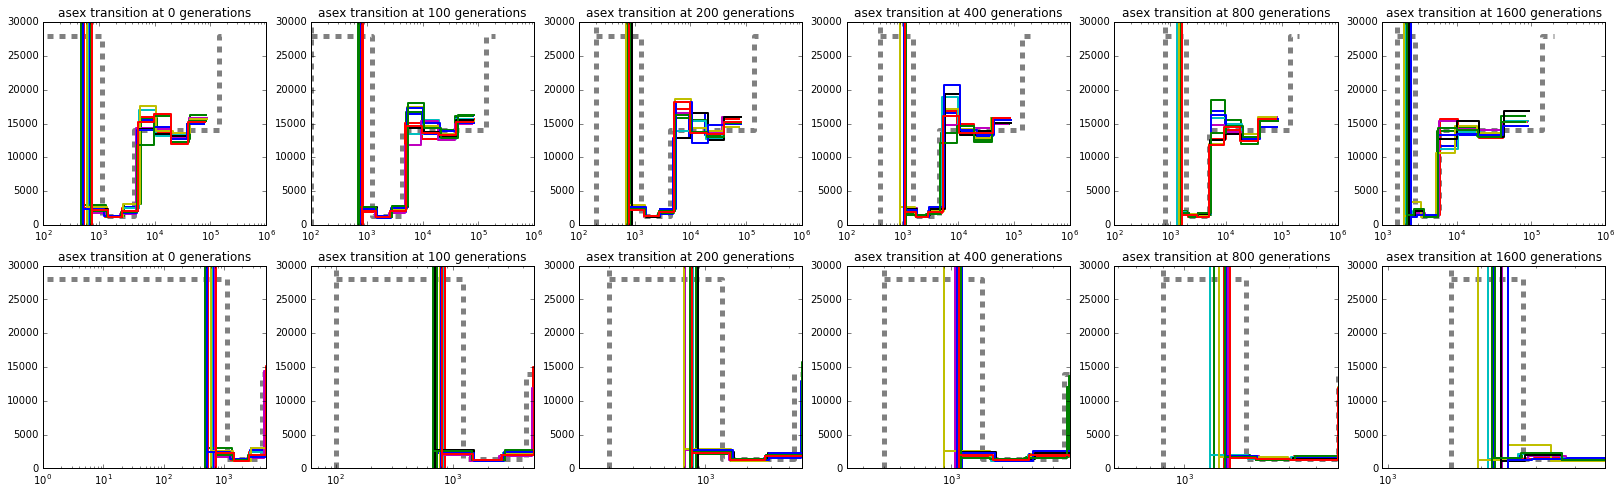

In [96]:
# read in the results
resultsDir = 'triploid_std_recent_data'
fig, axes = plt.subplots(nrows=2,ncols=len(numGens), figsize = (28,8))
for asex, axis in zip(numGens, axes[0]):
    rescaledAsex = float(asex) / (2.0 * trueN0)
    plot_psmc(axis, trueTs, trueNs, divtime = asex, logT = True, logN = False, lw = 5, ls = 'dashed', color = 'gray')
    axis.set_title('asex transition at {} generations'.format(asex))
    for rep in range(1, numReps+1):
        filename = '{rdir}/triploid_std_recent_asex{asex}_rep{rep}.results'.format(
            rdir = resultsDir,
            asex = rescaledAsex,
            rep = rep)
        try:
            result = read_tsmc_results(filename)
            result['truedivtime'] = rescaledAsex
            ts = get_unscaled_ts(result, mu, 100)
            Ns = get_Ns(result, mu, 100)
            estimatedDivtime = get_unscaled_divtime(result, mu, 100)
            plot_psmc(axis, ts, Ns, divtime = estimatedDivtime, logT = True, logN = False, lw=2)
        except:
            continue
for asex, axis in zip(numGens, axes[1]):
    rescaledAsex = float(asex) / (2.0 * trueN0)
    plot_psmc(axis, trueTs, trueNs, divtime = asex, logT = True, logN = False, lw = 5, ls = 'dashed', color = 'gray')
    axis.set_xlim((0.6*asex+1,5000))
    axis.set_title('asex transition at {} generations'.format(asex))
    for rep in range(1, numReps+1):
        filename = '{rdir}/triploid_std_recent_asex{asex}_rep{rep}.results'.format(
            rdir = resultsDir,
            asex = rescaledAsex,
            rep = rep)
        try:
            result = read_tsmc_results(filename)
            result['truedivtime'] = rescaledAsex
            ts = get_unscaled_ts(result, mu, 100)
            Ns = get_Ns(result, mu, 100)
            estimatedDivtime = get_unscaled_divtime(result, mu, 100)
            plot_psmc(axis, ts, Ns, divtime = estimatedDivtime, logT = True, logN = False, lw=2)
        except:
            continue
